# 1. Remarks
1.  Split dataset int train & test sets

2.  Do 4-fold cross validation.
    - Split train set into training & validation sets by 4-fold (i.e., 3 training parts + 1 validation part)
    - Train the models
    - We obtain 4 different trained models 
    - Evaluate those 4 trained models using test set
    
    
3.  Because using 4-fold cross validation, we need to do the feature extraction separately for each fold

    The reason is that we must standardize / normalize the feature (for training & validation sets) before fitting into the model
    
4.  Step-by-step doing feature extraction for each fold 
    * From the training set, we do:
        - SIFT + bags of visual words (i.e., k-means clustering) 
        - Gabor 
        - HOG + PCA 
        - LBP histogram + PCA
    *  Standardize the features for training set
    *  Fit obtained standardization into validation set and also test set 


In [1]:
import os

import pandas as pd

import numpy as np
from numpy import random

from random import sample

import matplotlib.pyplot as plt

import skimage
from skimage import io
from skimage.feature import local_binary_pattern
from skimage.color import label2rgb, rgb2gray
from skimage.transform import resize, rotate, downscale_local_mean, rescale

from scipy import ndimage as ndi
from skimage.util import img_as_float
from skimage.filters import gabor_kernel

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing
from skimage import exposure

from sklearn.preprocessing import Normalizer
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import StandardScaler

from tqdm.notebook import tqdm

# from tqdm import tqdm

import gc

from joblib import Parallel, delayed

In [2]:
from platform import python_version

print(python_version())

3.8.16


In [3]:
print(skimage.__version__)

0.19.2


# 1. Extract LBPH + PCA features

<u><b>Remarks:</b></u>
1. Read training-validation sets of a fold and test set
2. For training set:
    1. Extract LBP-H features: LBPH_list (num_of_images, num_of_HOG_feature)
    2. Standard deviation normalization the HOG_list. Let's say Std_scaler()
    3. Using PCA, analyze how many components to keep
    4. Reducing number of features of HOG 
3. For validation set:
    1. Extract HOG features
    2. Using previous Std_scaler(), which perform on the training set, to normalize the HOG features
    3. Apply PCA for dimension reduction
4. For test set:
    1. We do the same
    2. Just be careful about the filename. Because we have only 1 test set. e.g., we could have test_HOG_fold_1, test_HOG_fold_2,...
    

## 1.1. Core functions

In [115]:
img_blocks = 4
n_points=72
radius=2
n_bins = n_points
METHOD='uniform'

scales = [1.0, 0.75, 0.5, 0.25]

In [13]:
def compute_rotation_invariant_lbp_histogram(image, num_points, radius, num_bins):
    lbp = local_binary_pattern(image, num_points, radius, method='uniform')
    histogram, _ = np.histogram(lbp.ravel(), bins=num_bins, range=(0, num_bins))
    histogram = histogram.astype("float")
    histogram /= (histogram.sum() + 1e-7)
    return histogram

def divide_image_into_blocks(image, num_blocks):
    block_height = image.shape[0] // num_blocks
    block_width = image.shape[1] // num_blocks
    blocks = []
    for i in range(num_blocks):
        for j in range(num_blocks):
            block = image[i*block_height : (i+1)*block_height, j*block_width : (j+1)*block_width]
            blocks.append(block)
    return blocks

def compute_concatenated_lbp_histogram(image, num_points, radius, num_bins, num_blocks, scales):
    histograms = []
    for scale in scales:
        scaled_image = rescale(image, scale, mode='reflect')
        blocks = divide_image_into_blocks(scaled_image, num_blocks)
        for block in blocks:
            histogram = compute_rotation_invariant_lbp_histogram(block, num_points, radius, num_bins)
            histograms.append(histogram)
    concatenated_histogram = np.concatenate(histograms)
    return concatenated_histogram


concatenated_histogram = compute_concatenated_lbp_histogram(image, num_points, radius, num_bins, num_blocks, scales)

([], [])

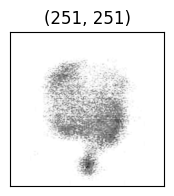

In [71]:
# demos
dfFoldTraining_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-training-fold_1.csv')

img = io.imread(dfFoldTraining_1["filenames"][0], as_gray=True)

plt.figure(figsize=(5,2))

plt.imshow(img,cmap='Greys_r')

plt.title(str(img.shape))
plt.xticks([])
plt.yticks([])

In [72]:
img.shape

(251, 251)

In [73]:
img_blocks = divide_image_into_blocks(img, 4)

display(np.asarray(img_blocks).shape)

(16, 62, 62)

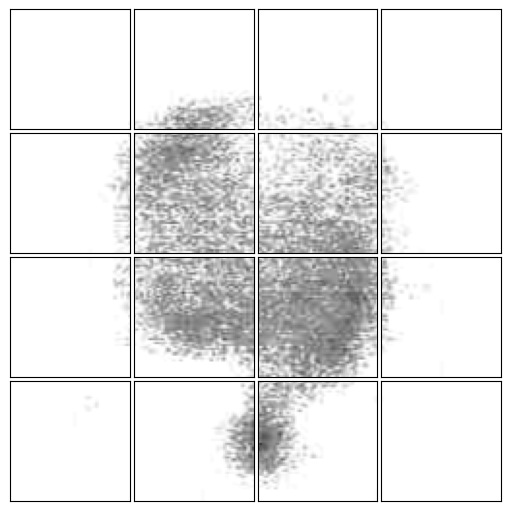

In [74]:
# Display all blocks in a single figure
num_plots = len(img_blocks)
num_cols = int(np.sqrt(num_plots))
num_rows = int(np.ceil(num_plots / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 5))


for i, ax in enumerate(axes.flat):
    if i < num_plots:
        ax.imshow(img_blocks[i],cmap='gray', vmin=0, vmax=255)
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
    else:
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)

fig.tight_layout(pad=0.3)
plt.show()


In [75]:
n_points=72
radius=2
n_bins = n_points
METHOD='uniform'

histograms=[]

for img_block in img_blocks:
    lbp = local_binary_pattern(img_block, n_points, radius, METHOD)
    histogram, _ = np.histogram(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins))
    
    histograms.append(histogram)
    
concatenated_histogram = np.concatenate(histograms)

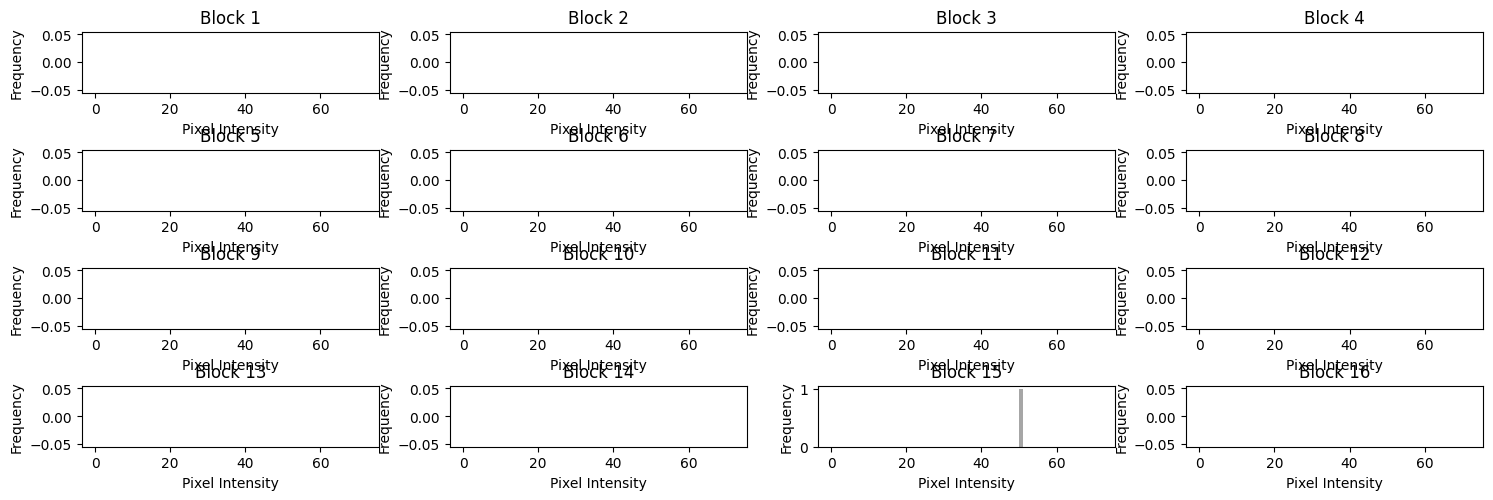

In [86]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))
fig.tight_layout(pad=2)

for i, ax in enumerate(axes.flat):
    if i < num_plots:
        ax.hist(img_blocks[i].ravel(), bins=n_bins, range=(0, n_bins), color='gray', alpha=0.7)
        ax.set_title(f'Block {i+1}')
        ax.set_xlabel('Pixel Intensity')
        ax.set_ylabel('Frequency')
    else:
        ax.axis('off')

plt.show()


In [107]:
histograms[i]

array([0.12700477, 0.02990897, 0.01127005, 0.01170351, 0.01560468,
       0.01170351, 0.01040312, 0.01733853, 0.0130039 , 0.01127005,
       0.01343736, 0.01083658, 0.00736888, 0.01170351, 0.00736888,
       0.00736888, 0.00736888, 0.00650195, 0.00650195, 0.0082358 ,
       0.0047681 , 0.00346771, 0.00606849, 0.00520156, 0.0047681 ,
       0.00996966, 0.00563502, 0.00433463, 0.00390117, 0.00650195,
       0.00346771, 0.00910273, 0.00433463, 0.00433463, 0.00130039,
       0.00433463, 0.00130039, 0.04594712, 0.00563502, 0.00606849,
       0.00390117, 0.0047681 , 0.00303424, 0.01083658, 0.00606849,
       0.0082358 , 0.00260078, 0.00650195, 0.00433463, 0.03771131,
       0.00520156, 0.00563502, 0.00520156, 0.00693541, 0.00650195,
       0.01473775, 0.00736888, 0.00736888, 0.00520156, 0.00996966,
       0.01083658, 0.01213697, 0.01127005, 0.00996966, 0.01083658,
       0.01213697, 0.01213697, 0.00996966, 0.00736888, 0.01517122,
       0.01083658, 0.22886866])

In [112]:
histograms[i].shape

(72,)

In [113]:
np.arange(histograms[i])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

(72,)

<BarContainer object of 72 artists>

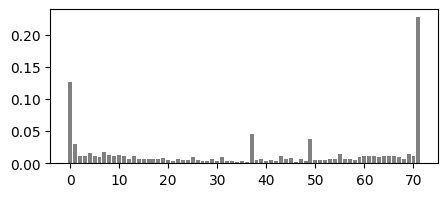

In [114]:
i=9

display(histograms[i].shape)

plt.figure(figsize=(5,2))

plt.bar(np.arange(len(histograms[i])),histograms[i], facecolor='0.5')

# plt.title(str(img.shape))
# plt.xticks([])
# plt.yticks([])

/tmp/ipykernel_18521/1398150271.py:5: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(28)
/tmp/ipykernel_18521/1398150271.py:7: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(28)


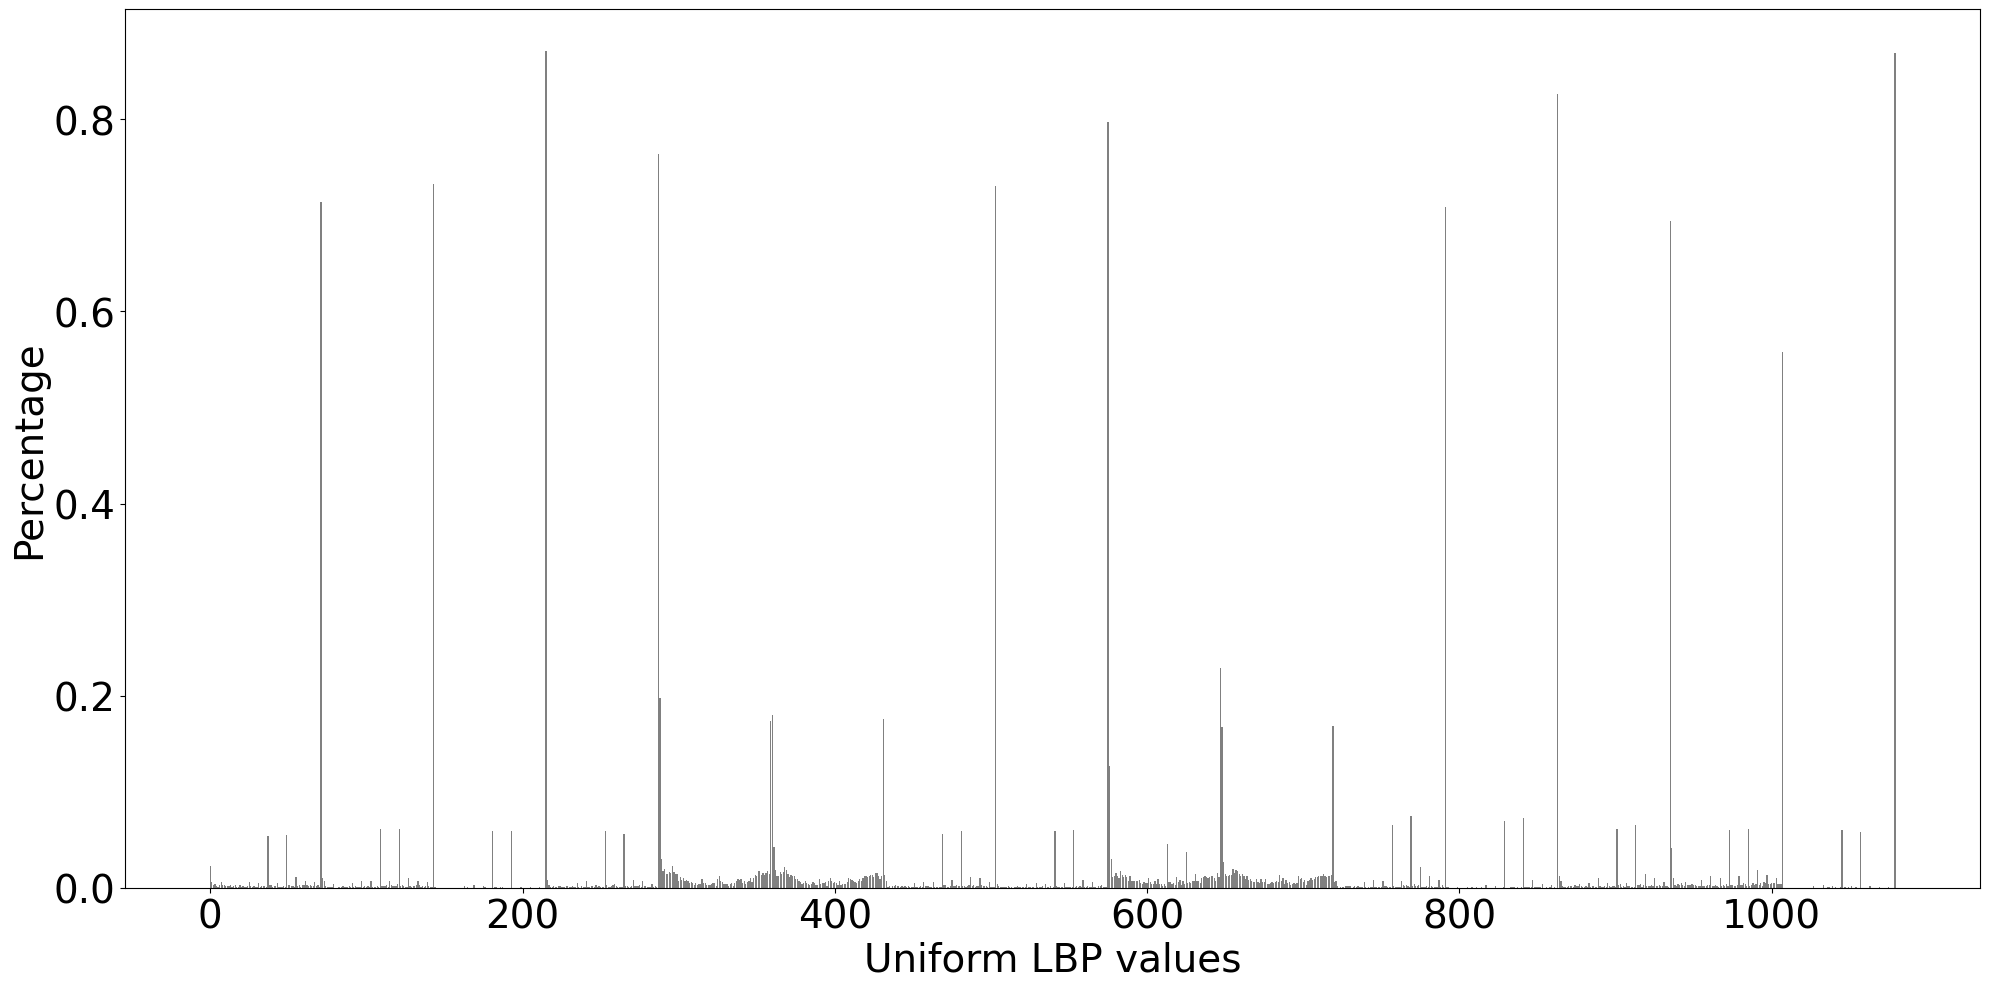

In [83]:
ig, ax = plt.subplots(figsize=(20, 10))
plt.bar( np.arange(len(concatenated_histogram)-72),concatenated_histogram[72:], facecolor='0.5')
# ax.set_ylim(top=np.max(counts[:-1]+1))
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(28)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(28)
# plt.show()                                                             
ax.set_xlabel('Uniform LBP values', fontsize=28)
ax.set_ylabel('Percentage', fontsize=28)
# ax.hist(hist, density=True, bins=n_bins, range=(0, n_bins), facecolor='0.5')

# ax.set_xlim(right=n_bins+4)
        
plt.tight_layout()
plt.show()

## 5.2. main()

### 5.2.1. For fold 1
#### 1. Read path of fold 1 file

In [ ]:
dfFoldTraining_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-training-fold_1.csv')
dfFoldValidation_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-validation-fold_1.csv')

#### 2. Extracting LBPH feature for the training set

In [ ]:
LBPH_list = extract_LBPH(dfFoldTraining_1)

In [ ]:
# create a standard deviation normalization for later uses
train_std_norm = StandardScaler().fit(LBPH_list)

In [ ]:
# Standard deviation normalization
LBPH_list_std = train_std_norm.transform(LBPH_list)

In [ ]:
display(LBPH_list_std)

In [ ]:
print('Total LBPH features:',(LBPH_list_std.shape))

#### 3. PCA analysis on the training set

In [ ]:
pca_LBPH_std = PCA().fit(LBPH_list_std)

##### 3.1. Plot PCA components and CEV

From this, we can know number of components to keep

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)

ax.plot(np.cumsum(pca_LBPH_std.explained_variance_ratio_)*100, linewidth=2)
ax.grid(color='r', linestyle='--', linewidth=1)

ax.set_xlabel('Number of components')
ax.set_ylabel('Cumulative explained variance');

ax.set_yticks(np.arange(0,105,5))
ax.set_xticks(np.arange(0,LBPH_list.shape[1],100))

ax.axhline(y=90, linewidth=3, color='g', alpha=0.5)

# ax.plot(800, 91, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")

ax.set_title("PCA analysis on LBPH features of training set")

In [ ]:
(np.cumsum(pca_LBPH_std.explained_variance_ratio_)*100)[700]

<b>Remarks: More than 90% of variance is explained by first 700 components</b>

##### 3.2. Kaiser's rule in statistics: Pick components which have eigenvalues >= 1 or 0.7


In [ ]:
fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)

ax.plot(pca_LBPH_std.explained_variance_, 'bo-', linewidth=2)
ax.grid(color='r', linestyle='--', linewidth=1)

ax.set_yticks(np.arange(0,125,5))
ax.set_xticks(np.arange(0,LBPH_list.shape[1],100))

ax.set_xlabel('Principal Component')
ax.set_ylabel('Eigenvalue')
plt.axhline(y=1, linewidth=1, color='g', alpha=0.5)
plt.title('Scree Plot of PCA: Component Eigenvalues')

In [ ]:
print('\nEigenvalues \n%s' %pca_LBPH_std.explained_variance_)
print('Eigenvectors \n%s' %pca_LBPH_std.components_)

In [ ]:
# kaiser's rule in statistics: Pick components which have eigenvalues >= 1 or 0.7
a = pca_LBPH_std.explained_variance_ >= 1.0

In [ ]:
a.sum()

<b> Only 115 components are significant and should be kept </b>

#### 4. Fit PCA to the LBPH features

1. We fit PCA (with n_components to keep) onto the training set
2. Transform the training set with that PCA
3. Use that PCA to transform the validation & test set

##### 4.1. For training set

In [ ]:
# keep 1100 components which contribute to > 90 %
pca_LBPH_std_2 = PCA(n_components=700)
pca_LBPH_std_2.fit(LBPH_list_std)
LBPH_PCA_train = pca_LBPH_std_2.transform(LBPH_list_std)
print("Original shape:   ", LBPH_list_std.shape)
print("Transformed shape:", LBPH_PCA_train.shape)

In [ ]:
# LBPH for train set --- standardization again
std_scale_train_2 = preprocessing.StandardScaler().fit(LBPH_PCA_train)

In [ ]:
# Save in file
X_LBPH_std_train = std_scale_train_2.transform(LBPH_PCA_train)
X_LBPH_train_dff = pd.DataFrame(data = X_LBPH_std_train)
X_LBPH_train_df = pd.DataFrame(data = dfFoldTraining_1["short_filenames"])

X_LBPH_train_df = pd.concat([X_LBPH_train_df,X_LBPH_train_dff], axis=1)
X_LBPH_train_df.columns = pd.RangeIndex(X_LBPH_train_df.columns.size)

display(X_LBPH_train_df.head(5), X_LBPH_train_df.shape)

X_LBPH_train_df.to_csv("..//_inputs//_image_features//new//X-LBPH_std_PCA_700_std-train-fold_1.csv", header=False, index=False)

##### 4.2. For validation set

In [ ]:
#Extract LBPH features for the validation set
LBPH_validation_list = extract_LBPH(dfFoldValidation_1)

In [ ]:
# standard deviation normalization
LBPH_validation_list_std = train_std_norm.transform(LBPH_validation_list)

In [ ]:
# Transform the LBPH features using above PCA fitting
LBPH_PCA_validation = pca_LBPH_std_2.transform(LBPH_validation_list_std)

In [ ]:
print("Original shape:   ", LBPH_validation_list.shape)
print("Transformed shape:", LBPH_PCA_validation.shape)

In [ ]:
# standard deviation normalization using above std_scale_train = preprocessing.StandardScaler().fit(LBPH_PCA_train)
X_LBPH_std_validation = std_scale_train_2.transform(LBPH_PCA_validation)

In [ ]:
X_LBPH_train_dff = pd.DataFrame(data = X_LBPH_std_validation)
X_LBPH_train_df = pd.DataFrame(data = dfFoldValidation_1["short_filenames"])

X_LBPH_train_df = pd.concat([X_LBPH_train_df,X_LBPH_train_dff], axis=1)
X_LBPH_train_df.columns = pd.RangeIndex(X_LBPH_train_df.columns.size)

display(X_LBPH_train_df.head(5), X_LBPH_train_df.shape)

X_LBPH_train_df.to_csv("..//_inputs//_image_features//new//X-LBPH_std_PCA_700_std-validation-fold_1.csv", header=False, index=False)

##### 4.2. For test set

<u><b> Remarks :</b></u> We use 4-fold cross validaiton. Then, we need also to compute each kind of features for test set.
So, for the test set, we extract 4 sets of features for each fold

In [ ]:
dfTest = pd.read_csv('..//_inputs//_images_Zooscan//ZooScan-test_img.csv')

In [ ]:
#Extract LBPH features for the test set
LBPH_test_list = extract_LBPH(dfTest)

In [ ]:
# standard deviation normalization 
LBPH_test_list_std = train_std_norm.transform(LBPH_test_list)
# Transform the LBPH features using above PCA fitting
LBPH_PCA_test = pca_LBPH_std_2.transform(LBPH_test_list_std)

In [ ]:
print("Original shape:   ", LBPH_test_list.shape)
print("Transformed shape:", LBPH_PCA_test.shape)

In [ ]:
# standard deviation normalization using above std_scale_train = preprocessing.StandardScaler().fit(LBPH_PCA_train)
X_LBPH_std_test = std_scale_train_2.transform(LBPH_PCA_test)

In [ ]:
X_LBPH_train_dff = pd.DataFrame(data = X_LBPH_std_test)
X_LBPH_train_df = pd.DataFrame(data = dfTest["short_filenames"])

X_LBPH_train_df = pd.concat([X_LBPH_train_df,X_LBPH_train_dff], axis=1)
X_LBPH_train_df.columns = pd.RangeIndex(X_LBPH_train_df.columns.size)

display(X_LBPH_train_df.head(5), X_LBPH_train_df.shape)

X_LBPH_train_df.to_csv("..//_inputs//_image_features//new//X-LBPH_std_PCA_700_std-test-fold_1.csv", header=False, index=False)

### 5.2.2. For fold 2
#### 1. Read path of fold 1 file

In [ ]:
dfFoldTraining_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-training-fold_2.csv')
dfFoldValidation_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-validation-fold_2.csv')

#### 2. Extracting LBPH feature for the training set

In [ ]:
LBPH_list = extract_LBPH(dfFoldTraining_1)

In [ ]:
# create a standard deviation normalization for later uses
train_std_norm = StandardScaler().fit(LBPH_list)

In [ ]:
# Standard deviation normalization
LBPH_list_std = train_std_norm.transform(LBPH_list)

In [ ]:
display(LBPH_list_std)

In [ ]:
print('Total LBPH features:',(LBPH_list_std.shape))

#### 3. PCA analysis on the training set

In [ ]:
pca_LBPH_std = PCA().fit(LBPH_list_std)

##### 3.1. Plot PCA components and CEV

From this, we can know number of components to keep

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)

ax.plot(np.cumsum(pca_LBPH_std.explained_variance_ratio_)*100, linewidth=2)
ax.grid(color='r', linestyle='--', linewidth=1)

ax.set_xlabel('Number of components')
ax.set_ylabel('Cumulative explained variance');

ax.set_yticks(np.arange(0,105,5))
ax.set_xticks(np.arange(0,LBPH_list.shape[1],100))

ax.axhline(y=90, linewidth=3, color='g', alpha=0.5)

# ax.plot(800, 91, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")

ax.set_title("PCA analysis on LBPH features of training set")

In [ ]:
(np.cumsum(pca_LBPH_std.explained_variance_ratio_)*100)[700]

<b>Remarks: More than 90% of variance is explained by first 700 components</b>

In [ ]:
print('\nEigenvalues \n%s' %pca_LBPH_std.explained_variance_)
print('Eigenvectors \n%s' %pca_LBPH_std.components_)

#### 4. Fit PCA to the LBPH features

1. We fit PCA (with n_components to keep) onto the training set
2. Transform the training set with that PCA
3. Use that PCA to transform the validation & test set

##### 4.1. For training set

In [ ]:
# keep 1100 components which contribute to > 90 %
pca_LBPH_std_2 = PCA(n_components=700)
pca_LBPH_std_2.fit(LBPH_list_std)
LBPH_PCA_train = pca_LBPH_std_2.transform(LBPH_list_std)
print("Original shape:   ", LBPH_list_std.shape)
print("Transformed shape:", LBPH_PCA_train.shape)

In [ ]:
# LBPH for train set --- standardization again
std_scale_train_2 = preprocessing.StandardScaler().fit(LBPH_PCA_train)

In [ ]:
# Save in file
X_LBPH_std_train = std_scale_train_2.transform(LBPH_PCA_train)
X_LBPH_train_dff = pd.DataFrame(data = X_LBPH_std_train)
X_LBPH_train_df = pd.DataFrame(data = dfFoldTraining_1["short_filenames"])

X_LBPH_train_df = pd.concat([X_LBPH_train_df,X_LBPH_train_dff], axis=1)
X_LBPH_train_df.columns = pd.RangeIndex(X_LBPH_train_df.columns.size)

display(X_LBPH_train_df.head(5), X_LBPH_train_df.shape)

X_LBPH_train_df.to_csv("..//_inputs//_image_features//new//X-LBPH_std_PCA_700_std-train-fold_2.csv", header=False, index=False)

##### 4.2. For validation set

In [ ]:
#Extract LBPH features for the validation set
LBPH_validation_list = extract_LBPH(dfFoldValidation_1)

In [ ]:
# standard deviation normalization
LBPH_validation_list_std = train_std_norm.transform(LBPH_validation_list)

In [ ]:
# Transform the LBPH features using above PCA fitting
LBPH_PCA_validation = pca_LBPH_std_2.transform(LBPH_validation_list_std)

In [ ]:
print("Original shape:   ", LBPH_validation_list.shape)
print("Transformed shape:", LBPH_PCA_validation.shape)

In [ ]:
# standard deviation normalization using above std_scale_train = preprocessing.StandardScaler().fit(LBPH_PCA_train)
X_LBPH_std_validation = std_scale_train_2.transform(LBPH_PCA_validation)

In [ ]:
X_LBPH_train_dff = pd.DataFrame(data = X_LBPH_std_validation)
X_LBPH_train_df = pd.DataFrame(data = dfFoldValidation_1["short_filenames"])

X_LBPH_train_df = pd.concat([X_LBPH_train_df,X_LBPH_train_dff], axis=1)
X_LBPH_train_df.columns = pd.RangeIndex(X_LBPH_train_df.columns.size)

display(X_LBPH_train_df.head(5), X_LBPH_train_df.shape)

X_LBPH_train_df.to_csv("..//_inputs//_image_features//new//X-LBPH_std_PCA_700_std-validation-fold_2.csv", header=False, index=False)

##### 4.2. For test set

<u><b> Remarks :</b></u> We use 4-fold cross validaiton. Then, we need also to compute each kind of features for test set.
So, for the test set, we extract 4 sets of features for each fold

In [ ]:
dfTest = pd.read_csv('..//_inputs//_images_Zooscan//ZooScan-test_img.csv')

In [ ]:
#Extract LBPH features for the test set
LBPH_test_list = extract_LBPH(dfTest)

In [ ]:
# standard deviation normalization 
LBPH_test_list_std = train_std_norm.transform(LBPH_test_list)
# Transform the LBPH features using above PCA fitting
LBPH_PCA_test = pca_LBPH_std_2.transform(LBPH_test_list_std)

In [ ]:
print("Original shape:   ", LBPH_test_list.shape)
print("Transformed shape:", LBPH_PCA_test.shape)

In [ ]:
# standard deviation normalization using above std_scale_train = preprocessing.StandardScaler().fit(LBPH_PCA_train)
X_LBPH_std_test = std_scale_train_2.transform(LBPH_PCA_test)

In [ ]:
X_LBPH_train_dff = pd.DataFrame(data = X_LBPH_std_test)
X_LBPH_train_df = pd.DataFrame(data = dfTest["short_filenames"])

X_LBPH_train_df = pd.concat([X_LBPH_train_df,X_LBPH_train_dff], axis=1)
X_LBPH_train_df.columns = pd.RangeIndex(X_LBPH_train_df.columns.size)

display(X_LBPH_train_df.head(5), X_LBPH_train_df.shape)

X_LBPH_train_df.to_csv("..//_inputs//_image_features//new//X-LBPH_std_PCA_700_std-test-fold_2.csv", header=False, index=False)

### 3.1. Function definition

### 5.2.3. For fold 3

#### 1. Read path of fold 1 file

In [ ]:
dfFoldTraining_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-training-fold_3.csv')
dfFoldValidation_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-validation-fold_3.csv')

#### 2. Extracting LBPH feature for the training set

In [ ]:
LBPH_list = extract_LBPH(dfFoldTraining_1)

In [ ]:
# create a standard deviation normalization for later uses
train_std_norm = StandardScaler().fit(LBPH_list)

In [ ]:
# Standard deviation normalization
LBPH_list_std = train_std_norm.transform(LBPH_list)

In [ ]:
display(LBPH_list_std)

In [ ]:
print('Total LBPH features:',(LBPH_list_std.shape))

#### 3. PCA analysis on the training set

In [ ]:
pca_LBPH_std = PCA().fit(LBPH_list_std)

##### 3.1. Plot PCA components and CEV

From this, we can know number of components to keep

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)

ax.plot(np.cumsum(pca_LBPH_std.explained_variance_ratio_)*100, linewidth=2)
ax.grid(color='r', linestyle='--', linewidth=1)

ax.set_xlabel('Number of components')
ax.set_ylabel('Cumulative explained variance');

ax.set_yticks(np.arange(0,105,5))
ax.set_xticks(np.arange(0,LBPH_list.shape[1],100))

ax.axhline(y=90, linewidth=3, color='g', alpha=0.5)

# ax.plot(800, 91, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")

ax.set_title("PCA analysis on LBPH features of training set")

In [ ]:
(np.cumsum(pca_LBPH_std.explained_variance_ratio_)*100)[700]

<b>Remarks: More than 90% of variance is explained by first 700 components</b>

In [ ]:
print('\nEigenvalues \n%s' %pca_LBPH_std.explained_variance_)
print('Eigenvectors \n%s' %pca_LBPH_std.components_)

#### 4. Fit PCA to the LBPH features

1. We fit PCA (with n_components to keep) onto the training set
2. Transform the training set with that PCA
3. Use that PCA to transform the validation & test set

##### 4.1. For training set

In [ ]:
# keep 700 components which contribute to > 90 %
pca_LBPH_std_2 = PCA(n_components=700)
pca_LBPH_std_2.fit(LBPH_list_std)
LBPH_PCA_train = pca_LBPH_std_2.transform(LBPH_list_std)
print("Original shape:   ", LBPH_list_std.shape)
print("Transformed shape:", LBPH_PCA_train.shape)

In [ ]:
# LBPH for train set --- standardization again
std_scale_train_2 = preprocessing.StandardScaler().fit(LBPH_PCA_train)

In [ ]:
# Save in file
X_LBPH_std_train = std_scale_train_2.transform(LBPH_PCA_train)
X_LBPH_train_dff = pd.DataFrame(data = X_LBPH_std_train)
X_LBPH_train_df = pd.DataFrame(data = dfFoldTraining_1["short_filenames"])

X_LBPH_train_df = pd.concat([X_LBPH_train_df,X_LBPH_train_dff], axis=1)
X_LBPH_train_df.columns = pd.RangeIndex(X_LBPH_train_df.columns.size)

display(X_LBPH_train_df.head(5), X_LBPH_train_df.shape)

X_LBPH_train_df.to_csv("..//_inputs//_image_features//new//X-LBPH_std_PCA_700_std-train-fold_3.csv", header=False, index=False)

##### 4.2. For validation set

In [ ]:
#Extract LBPH features for the validation set
LBPH_validation_list = extract_LBPH(dfFoldValidation_1)

In [ ]:
# standard deviation normalization
LBPH_validation_list_std = train_std_norm.transform(LBPH_validation_list)

In [ ]:
# Transform the LBPH features using above PCA fitting
LBPH_PCA_validation = pca_LBPH_std_2.transform(LBPH_validation_list_std)

In [ ]:
print("Original shape:   ", LBPH_validation_list.shape)
print("Transformed shape:", LBPH_PCA_validation.shape)

In [ ]:
# standard deviation normalization using above std_scale_train = preprocessing.StandardScaler().fit(LBPH_PCA_train)
X_LBPH_std_validation = std_scale_train_2.transform(LBPH_PCA_validation)

In [ ]:
X_LBPH_train_dff = pd.DataFrame(data = X_LBPH_std_validation)
X_LBPH_train_df = pd.DataFrame(data = dfFoldValidation_1["short_filenames"])

X_LBPH_train_df = pd.concat([X_LBPH_train_df,X_LBPH_train_dff], axis=1)
X_LBPH_train_df.columns = pd.RangeIndex(X_LBPH_train_df.columns.size)

display(X_LBPH_train_df.head(5), X_LBPH_train_df.shape)

X_LBPH_train_df.to_csv("..//_inputs//_image_features//new//X-LBPH_std_PCA_700_std-validation-fold_3.csv", header=False, index=False)

##### 4.2. For test set

<u><b> Remarks :</b></u> We use 4-fold cross validaiton. Then, we need also to compute each kind of features for test set.
So, for the test set, we extract 4 sets of features for each fold

In [ ]:
dfTest = pd.read_csv('..//_inputs//_images_Zooscan//ZooScan-test_img.csv')

In [ ]:
#Extract LBPH features for the test set
LBPH_test_list = extract_LBPH(dfTest)

In [ ]:
# standard deviation normalization 
LBPH_test_list_std = train_std_norm.transform(LBPH_test_list)
# Transform the LBPH features using above PCA fitting
LBPH_PCA_test = pca_LBPH_std_2.transform(LBPH_test_list_std)

In [ ]:
print("Original shape:   ", LBPH_test_list.shape)
print("Transformed shape:", LBPH_PCA_test.shape)

In [ ]:
# standard deviation normalization using above std_scale_train = preprocessing.StandardScaler().fit(LBPH_PCA_train)
X_LBPH_std_test = std_scale_train_2.transform(LBPH_PCA_test)

In [ ]:
X_LBPH_train_dff = pd.DataFrame(data = X_LBPH_std_test)
X_LBPH_train_df = pd.DataFrame(data = dfTest["short_filenames"])

X_LBPH_train_df = pd.concat([X_LBPH_train_df,X_LBPH_train_dff], axis=1)
X_LBPH_train_df.columns = pd.RangeIndex(X_LBPH_train_df.columns.size)

display(X_LBPH_train_df.head(5), X_LBPH_train_df.shape)

X_LBPH_train_df.to_csv("..//_inputs//_image_features//new//X-LBPH_std_PCA_700_std-test-fold_3.csv", header=False, index=False)

### 3.1. Function definition

### 5.2.4. For fold 4

#### 1. Read path of fold 1 file

In [ ]:
dfFoldTraining_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-training-fold_4.csv')
dfFoldValidation_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-validation-fold_4.csv')

#### 2. Extracting LBPH feature for the training set

In [ ]:
LBPH_list = extract_LBPH(dfFoldTraining_1)

In [ ]:
# create a standard deviation normalization for later uses
train_std_norm = StandardScaler().fit(LBPH_list)

In [ ]:
# Standard deviation normalization
LBPH_list_std = train_std_norm.transform(LBPH_list)

In [ ]:
display(LBPH_list_std)

In [ ]:
print('Total LBPH features:',(LBPH_list_std.shape))

#### 3. PCA analysis on the training set

In [ ]:
pca_LBPH_std = PCA().fit(LBPH_list_std)

##### 3.1. Plot PCA components and CEV

From this, we can know number of components to keep

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)

ax.plot(np.cumsum(pca_LBPH_std.explained_variance_ratio_)*100, linewidth=2)
ax.grid(color='r', linestyle='--', linewidth=1)

ax.set_xlabel('Number of components')
ax.set_ylabel('Cumulative explained variance');

ax.set_yticks(np.arange(0,105,5))
ax.set_xticks(np.arange(0,LBPH_list.shape[1],100))

ax.axhline(y=90, linewidth=3, color='g', alpha=0.5)

# ax.plot(800, 91, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")

ax.set_title("PCA analysis on LBPH features of training set")

In [ ]:
(np.cumsum(pca_LBPH_std.explained_variance_ratio_)*100)[700]

<b>Remarks: More than 90% of variance is explained by first 700 components</b>

In [ ]:
print('\nEigenvalues \n%s' %pca_LBPH_std.explained_variance_)
print('Eigenvectors \n%s' %pca_LBPH_std.components_)

#### 4. Fit PCA to the LBPH features

1. We fit PCA (with n_components to keep) onto the training set
2. Transform the training set with that PCA
3. Use that PCA to transform the validation & test set

##### 4.1. For training set

In [ ]:
# keep 700 components which contribute to > 90 %
pca_LBPH_std_2 = PCA(n_components=700)
pca_LBPH_std_2.fit(LBPH_list_std)
LBPH_PCA_train = pca_LBPH_std_2.transform(LBPH_list_std)
print("Original shape:   ", LBPH_list_std.shape)
print("Transformed shape:", LBPH_PCA_train.shape)

In [ ]:
# LBPH for train set --- standardization again
std_scale_train_2 = preprocessing.StandardScaler().fit(LBPH_PCA_train)

In [ ]:
# Save in file
X_LBPH_std_train = std_scale_train_2.transform(LBPH_PCA_train)
X_LBPH_train_dff = pd.DataFrame(data = X_LBPH_std_train)
X_LBPH_train_df = pd.DataFrame(data = dfFoldTraining_1["short_filenames"])

X_LBPH_train_df = pd.concat([X_LBPH_train_df,X_LBPH_train_dff], axis=1)
X_LBPH_train_df.columns = pd.RangeIndex(X_LBPH_train_df.columns.size)

display(X_LBPH_train_df.head(5), X_LBPH_train_df.shape)

X_LBPH_train_df.to_csv("..//_inputs//_image_features//new//X-LBPH_std_PCA_700_std-train-fold_4.csv", header=False, index=False)

##### 4.2. For validation set

In [ ]:
#Extract LBPH features for the validation set
LBPH_validation_list = extract_LBPH(dfFoldValidation_1)

In [ ]:
# standard deviation normalization
LBPH_validation_list_std = train_std_norm.transform(LBPH_validation_list)

In [ ]:
# Transform the LBPH features using above PCA fitting
LBPH_PCA_validation = pca_LBPH_std_2.transform(LBPH_validation_list_std)

In [ ]:
print("Original shape:   ", LBPH_validation_list.shape)
print("Transformed shape:", LBPH_PCA_validation.shape)

In [ ]:
# standard deviation normalization using above std_scale_train = preprocessing.StandardScaler().fit(LBPH_PCA_train)
X_LBPH_std_validation = std_scale_train_2.transform(LBPH_PCA_validation)

In [ ]:
X_LBPH_train_dff = pd.DataFrame(data = X_LBPH_std_validation)
X_LBPH_train_df = pd.DataFrame(data = dfFoldValidation_1["short_filenames"])

X_LBPH_train_df = pd.concat([X_LBPH_train_df,X_LBPH_train_dff], axis=1)
X_LBPH_train_df.columns = pd.RangeIndex(X_LBPH_train_df.columns.size)

display(X_LBPH_train_df.head(5), X_LBPH_train_df.shape)

X_LBPH_train_df.to_csv("..//_inputs//_image_features//new//X-LBPH_std_PCA_700_std-validation-fold_4.csv", header=False, index=False)

##### 4.2. For test set

<u><b> Remarks :</b></u> We use 4-fold cross validaiton. Then, we need also to compute each kind of features for test set.
So, for the test set, we extract 4 sets of features for each fold

In [ ]:
dfTest = pd.read_csv('..//_inputs//_images_Zooscan//ZooScan-test_img.csv')

In [ ]:
#Extract LBPH features for the test set
LBPH_test_list = extract_LBPH(dfTest)

In [ ]:
# standard deviation normalization 
LBPH_test_list_std = train_std_norm.transform(LBPH_test_list)
# Transform the LBPH features using above PCA fitting
LBPH_PCA_test = pca_LBPH_std_2.transform(LBPH_test_list_std)

In [ ]:
print("Original shape:   ", LBPH_test_list.shape)
print("Transformed shape:", LBPH_PCA_test.shape)

In [ ]:
# standard deviation normalization using above std_scale_train = preprocessing.StandardScaler().fit(LBPH_PCA_train)
X_LBPH_std_test = std_scale_train_2.transform(LBPH_PCA_test)

In [ ]:
X_LBPH_train_dff = pd.DataFrame(data = X_LBPH_std_test)
X_LBPH_train_df = pd.DataFrame(data = dfTest["short_filenames"])

X_LBPH_train_df = pd.concat([X_LBPH_train_df,X_LBPH_train_dff], axis=1)
X_LBPH_train_df.columns = pd.RangeIndex(X_LBPH_train_df.columns.size)

display(X_LBPH_train_df.head(5), X_LBPH_train_df.shape)

X_LBPH_train_df.to_csv("..//_inputs//_image_features//new//X-LBPH_std_PCA_700_std-test-fold_4.csv", header=False, index=False)

### 3.1. Function definition

# 6. Extract Gabor features

<u><b>Remarks:</b></u>
1. Read training-validation sets of a fold and test set
2. For training set:
    1. Extract LBP-H features: LBPH_list (num_of_images, num_of_HOG_feature)
    2. Standard deviation normalization the HOG_list. Let's say Std_scaler()
    3. Using PCA, analyze how many components to keep
    4. Reducing number of features of HOG 
3. For validation set:
    1. Extract HOG features
    2. Using previous Std_scaler(), which perform on the training set, to normalize the HOG features
    3. Apply PCA for dimension reduction
4. For test set:
    1. We do the same
    2. Just be careful about the filename. Because we have only 1 test set. e.g., we could have test_HOG_fold_1, test_HOG_fold_2,...
    

In [ ]:
# gabor filter

def createGaborfilterbank(m=39, n=39):
    garray = []
    fmax = 0.327 # maximum frequency
    gamma = np.sqrt(2)
    eta = np.sqrt(2)
    
    gamma = 0.5
    eta = 0.5
    
    u = 6 #number of frequencies
    v = 8 #number of orientation

    for i in range(0,u):

        fu = fmax/np.sqrt(2)**(i); # frequency
        alpha = fu/gamma;
        beta = fu/eta;

        for j in range(0,v):
            theta = j/v*np.pi; # orientation 

            x, y = np.meshgrid(np.arange(1,n+1,1), np.arange(1,m+1,1))

            xenvolope  =  (x-((m+1)/2))*np.cos(theta) + (y-((n+1)/2))*np.sin(theta);
            yenvolope  = -(x-((m+1)/2))*np.sin(theta) + (y-((n+1)/2))*np.cos(theta);
            
            gfilter = np.transpose(
                                (fu**2/(np.pi*gamma*eta))*np.exp(-((alpha**2)*(xenvolope**2) + 
                              (beta**2)*(yenvolope**2)))*np.exp(1j*2*np.pi*fu*xenvolope)
                                    );

            garray.append(gfilter);

    plt.figure(figsize=(15,10))

    for i in range(48):    
        ax = plt.subplot(6,8,i+1)
        # ax.set_title(label)
        plt.imshow(np.real(garray[i]),cmap='Greys_r')
        plt.axis("off")  
        
    return garray

def computeGaborfeatures(image, kernels):
    feats = []
    filteredimg = []
    
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, np.abs(kernel), mode='wrap')
            
        feats.append(filtered.mean())
        feats.append(filtered.std())
        
        filteredimg.append(filtered)
        
    return feats, filteredimg

In [ ]:
0.327/np.sqrt(2)

In [ ]:
for j in range(0,8):
    display(j/8*np.pi)

In [ ]:
m=7
n=7
v=8
gamma =0.5
eta=0.5
fu = 0.327/np.sqrt(2)**(0); # frequency
alpha = fu/0.5;
beta = fu/0.5;
theta = j/v*np.pi; # orientation 

In [ ]:
fu

In [ ]:
theta

In [ ]:


x, y = np.meshgrid(np.arange(1,n+1,1), np.arange(1,m+1,1))

xenvolope  =  (x-((m+1)/2))*np.cos(theta) + (y-((n+1)/2))*np.sin(theta);
yenvolope  = -(x-((m+1)/2))*np.sin(theta) + (y-((n+1)/2))*np.cos(theta);

display(xenvolope, yenvolope)

In [ ]:
gfilter = np.transpose(
                        (fu**2/(np.pi*gamma*eta))*np.exp(-((alpha**2)*(xenvolope**2) + 
                      (beta**2)*(yenvolope**2)))*np.exp(1j*2*np.pi*fu*xenvolope)
                            );

In [ ]:
gfilter

In [ ]:
gfilter.shape

In [ ]:
-6.05587208e-05-1.19127798e-05

In [ ]:
Gabor_kernels = createGaborfilterbank(m=43, n=43)

In [ ]:
Gabor_kernels[0].shape

In [ ]:
img = io.imread(dfFoldTraining_1["filenames"][0])

In [ ]:
feartures, imgfiltered = computeGaborfeatures(img_as_float(img), Gabor_kernels)

In [ ]:
plt.figure(figsize=(15,10))

for i in range(48):    
    ax = plt.subplot(6,8,i+1)
    # ax.set_title(label)
    plt.imshow((imgfiltered[i]), cmap='Greys_r')
    plt.axis("off")

In [ ]:
np.asarray(feartures).shape

In [ ]:
# SIFT
def extract_SIFT_from_image(fname):   
    img = io.imread(fname, as_gray=True)
#     img = (resize(img,(256,256))*255).astype(np.uint8)
    
    # Adaptive Equalization
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    
    # extract daisy descriptor
    descriptor_extractor = SIFT()
    try:
        descriptor_extractor.detect_and_extract(img_adapteq)
    except:
        img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.1)
        descriptor_extractor.detect_and_extract(img_adapteq)
        
    sift_feature = descriptor_extractor.descriptors
    
    return sift_feature


def extract_sift_feature_BOVW_from_image(fname,sift_cluster_model):    
    
    sift_features=extract_SIFT_from_image(fname)     
    
    bovw_feature = np.histogram(sift_cluster_model.predict(sift_features), bins=range(sift_cluster_model.n_clusters), density=True)[0]

    return bovw_feature

### 3.2. Work on images of training set

In [ ]:
number_of_clusters = 512
batch_size = 1000

kmeans = MiniBatchKMeans(n_clusters=number_of_clusters,batch_size=batch_size, n_init="auto")

number_of_batch = len(X_train_df)// batch_size + 1

list_batches = np.array_split(X_train_df["filenames"], number_of_batch)
    
    
for batch in tqdm(list_batches, desc='batch', leave=True, colour='green'):      
    
    sift_descriptor_list = Parallel(n_jobs=8)(
            delayed(extract_SIFT_from_image)(filename) for filename in batch
        )
    
    sift_descriptor_list_concat = np.concatenate(sift_descriptor_list)

    # %reset_selective -f sift_descriptor_list
    del sift_descriptor_list                                
    gc.collect()
                                    
    kmeans = kmeans.partial_fit(sift_descriptor_list_concat)
    
    # %reset_selective -f sift_descriptor_list_concat
                                    
    del sift_descriptor_list_concat
    
    gc.collect()

In [ ]:
for batch in list_batches:  
    sift_descriptor_list = Parallel(n_jobs=-1)(
            delayed(extract_SIFT_from_image)(filename) for filename in batch
        )

    # for filname in batch:


    kmeans = kmeans.partial_fit(np.concatenate(sift_descriptor_list))

    del sift_descriptor_list
    gc.collect()

In [ ]:
list_batches[0][0]

In [ ]:
import pickle
# pickle.dump(kmeans, open("..//_inputs//_image_features//new//sift_kmeans_512_model.pkl", "wb"))

In [ ]:
# load the model from disk
loaded_model = pickle.load(open("..//_inputs//_image_features//new//sift_kmeans_512_model.pkl", 'rb'))

In [ ]:
sift_decs = extract_sift_feature_BOVW_from_image(X_train_df["filenames"][40500], loaded_model)

In [ ]:
sift_decs.shape

In [ ]:
sift_features=extract_SIFT_from_image(X_train_df["filenames"][40500]) 

In [ ]:
sift_decs = np.histogram(loaded_model.predict(sift_features), bins=loaded_model.n_clusters, range=(0, loaded_model.n_clusters), density=True)[0]
display(sift_decs)

In [ ]:
sift_decs2 = np.histogram(loaded_model.predict(sift_features), bins=range(loaded_model.n_clusters), density=True)[0]
display(sift_decs2)

In [ ]:
sift_decs[0:511] - sift_decs2

In [ ]:
sift_decs[0][0]

In [ ]:
number_of_clusters = 512
batch_sise = 1000

number_of_batch = len(X_train_df)// batch_sise + 1

list_batches = np.array_split(X_train_df["filenames"], number_of_batch)

sift_descriptor_list = Parallel(n_jobs=6)(
            delayed(extract_sift_feature_BOVW_from_image)(fname, loaded_model) for fname in tqdm(list_batches[0])
        )

sift_BOVW = np.array(sift_descriptor_list)
del sift_descriptor_list
gc.collect()
    
for batch in tqdm(list_batches[1:], desc='batch', position=1, leave=False, colour='green'):    
    sift_descriptor_list = Parallel(n_jobs=6)(
            delayed(extract_sift_feature_BOVW_from_image)(fname, loaded_model) for fname in tqdm(batch)
        )

    sift_BOVW = np.vstack((sift_BOVW, np.array(sift_descriptor_list)))
    
    del sift_descriptor_list
    gc.collect()

        

In [ ]:
sift_BOVW.shape

In [ ]:
X_daisy_train_dff = pd.DataFrame(data = sift_BOVW)
X_daisy_train_df = pd.DataFrame(data = X_train_df["short_filenames"])

X_daisy_train_df = pd.concat([X_daisy_train_df,X_daisy_train_dff], axis=1)
X_daisy_train_df.columns = pd.RangeIndex(X_daisy_train_df.columns.size)

display(X_daisy_train_df.head(5), X_daisy_train_df.shape)

X_daisy_train_df.to_csv("..//_inputs//_image_features//new//X-sift_512_features-train_df.csv", header=False, index=False)

# standardized version of daisy train set
std_scale_train = preprocessing.StandardScaler().fit(sift_BOVW)

X_daisy_train_std = std_scale_train.transform(sift_BOVW)

X_daisy_train_dff = pd.DataFrame(data = X_daisy_train_std)
X_daisy_train_df = pd.DataFrame(data = X_train_df["short_filenames"])

X_daisy_train_df = pd.concat([X_daisy_train_df,X_daisy_train_dff], axis=1)
X_daisy_train_df.columns = pd.RangeIndex(X_daisy_train_df.columns.size)

display(X_daisy_train_df.head(5), X_daisy_train_df.shape)

X_daisy_train_df.to_csv("..//_inputs//_image_features//new//X-sift_512_std_features-train_df.csv", header=False, index=False)

In [ ]:
number_of_clusters = 512
batch_sise = 1000

number_of_batch = len(X_validation_df)// batch_sise + 1

list_batches = np.array_split(X_validation_df["filenames"], number_of_batch)

sift_descriptor_list = Parallel(n_jobs=6)(
            delayed(extract_sift_feature_BOVW_from_image)(fname, loaded_model) for fname in tqdm(list_batches[0])
        )

sift_BOVW = np.array(sift_descriptor_list)
del sift_descriptor_list
gc.collect()
    
for batch in tqdm(list_batches[1:], desc='batch', position=1, leave=False, colour='green'):    
    sift_descriptor_list = Parallel(n_jobs=6)(
            delayed(extract_sift_feature_BOVW_from_image)(fname, loaded_model) for fname in tqdm(batch)
        )

    sift_BOVW = np.vstack((sift_BOVW, np.array(sift_descriptor_list)))
    
    del sift_descriptor_list
    gc.collect()

In [ ]:
sift_BOVW.shape

In [ ]:
std_scale_train

In [ ]:

X_daisy_validation_dff = pd.DataFrame(data = sift_BOVW)
X_daisy_validation_df = pd.DataFrame(data = X_validation_df["short_filenames"])

X_daisy_validation_df = pd.concat([X_daisy_validation_df,X_daisy_validation_dff], axis=1)
X_daisy_validation_df.columns = pd.RangeIndex(X_daisy_validation_df.columns.size)

display(X_daisy_validation_df.head(5), X_daisy_validation_df.shape)

X_daisy_validation_df.to_csv("..//_inputs//_image_features//new//X-sift_512_features-validation_df.csv", header=False, index=False)

# standardized version of daisy validation set
X_daisy_validation_std = std_scale_train.transform(sift_BOVW)

X_daisy_validation_dff = pd.DataFrame(data = X_daisy_validation_std)
X_daisy_validation_df = pd.DataFrame(data = X_validation_df["short_filenames"])

X_daisy_validation_df = pd.concat([X_daisy_validation_df,X_daisy_validation_dff], axis=1)
X_daisy_validation_df.columns = pd.RangeIndex(X_daisy_validation_df.columns.size)

display(X_daisy_validation_df.head(5), X_daisy_validation_df.shape)

X_daisy_validation_df.to_csv("..//_inputs//_image_features//new//X-sift_512_std_features-validation_df.csv", header=False, index=False)


In [ ]:
list_batches[0]

In [ ]:
for fname in tqdm(list_batches[0]):
    sift_fea = extract_SIFT_from_image(fname)
    if sift_fea.shape[0] == 0:
        display(fname)
        break;
    

In [ ]:
number_of_clusters = 512
batch_sise = 1000

number_of_batch = len(X_test_df)// batch_sise + 1

list_batches = np.array_split(X_test_df["filenames"], number_of_batch)

sift_descriptor_list = Parallel(n_jobs=6)(
            delayed(extract_sift_feature_BOVW_from_image)(fname, loaded_model) for fname in tqdm(list_batches[0])
        )

sift_BOVW = np.array(sift_descriptor_list)

display(sift_BOVW.shape)

del sift_descriptor_list
gc.collect()
    
for batch in tqdm(list_batches[1:], desc='batch', position=1, leave=False, colour='green'):    
    sift_descriptor_list = Parallel(n_jobs=6)(
            delayed(extract_sift_feature_BOVW_from_image)(fname, loaded_model) for fname in tqdm(batch)
        )

    sift_BOVW = np.vstack((sift_BOVW, np.array(sift_descriptor_list)))
    
    del sift_descriptor_list
    gc.collect()
    
display(sift_BOVW.shape)

In [ ]:
X_daisy_test_dff = pd.DataFrame(data = sift_BOVW)
X_daisy_test_df = pd.DataFrame(data = X_test_df["short_filenames"])

X_daisy_test_df = pd.concat([X_daisy_test_df,X_daisy_test_dff], axis=1)
X_daisy_test_df.columns = pd.RangeIndex(X_daisy_test_df.columns.size)

display(X_daisy_test_df.head(5), X_daisy_test_df.shape)

X_daisy_test_df.to_csv("..//_inputs//_image_features//new//X-sift_512_features-test_df.csv", header=False, index=False)

# standardized version of daisy validation set
X_daisy_test_std = std_scale_train.transform(sift_BOVW)

X_daisy_test_dff = pd.DataFrame(data = X_daisy_test_std)
X_daisy_test_df = pd.DataFrame(data = X_test_df["short_filenames"])

X_daisy_test_df = pd.concat([X_daisy_test_df,X_daisy_test_dff], axis=1)
X_daisy_test_df.columns = pd.RangeIndex(X_daisy_test_df.columns.size)

display(X_daisy_test_df.head(5), X_daisy_test_df.shape)

X_daisy_test_df.to_csv("..//_inputs//_image_features//new//X-sift_512_std_features-test_df.csv", header=False, index=False)


In [ ]:
number_of_clusters = 512
batch_sise = 1000

kmeans = MiniBatchKMeans(n_clusters=number_of_clusters,batch_size=batch_sise)

number_of_batch = len(X_train_df)// batch_sise + 1

list_batches = np.array_split(X_train_df["filenames"], number_of_batch)

for batch in tqdm(list_batches, desc='batch', position=1, leave=False, colour='green'):    

    daisy_descriptor_list=[] ##list to store all daisy descriptors to form our visual vocabulary by clustering

    # for i in tqdm(range(len(batch)), desc='filename', position=1, leave=False, colour='red', ncols=80):
    for fname in tqdm(batch, desc='filenames', position=2, leave=True, colour='red'):
        img = io.imread(fname, as_gray=True)
        # extract sift features
        # fname = batch[i]
        sift_features=extract_SIFT_from_image(img)

        # save in a map    
        daisy_descriptor_list=daisy_descriptor_list+list(daisy_features)

    kmeans = kmeans.partial_fit(np.concatenate(daisy_descriptor_list))
    
    del daisy_descriptor_list
    gc.collect()

In [ ]:
kmeans = MiniBatchKMeans(n_clusters=10,batch_size=100)

In [ ]:
descriptors = Parallel(n_jobs=-1)(
            delayed(extract_SIFT_from_image)(filename) for filename in X_train_df["filenames"][0:100]
        )

In [ ]:
np.concatenate(descriptors).shape

In [ ]:
np.array(descriptors).shape

In [ ]:
kmeans

In [ ]:
import pickle
pickle.dump(kmeans, open("..//_inputs//_image_features//new//daisy_kmeans_512_model.pkl", "wb"))

In [ ]:
pickle.dump(kmeans, open("..//_inputs//_image_features//new//daisy_kmeans_512_model.pkl", "wb"))

In [ ]:
#Daisy for train set

img = io.imread(X_train_df["filenames"][0])
X_daisy_train = extract_daisy_feature_BOVW_from_image(img,kmeans)

for fname in tqdm(X_train_df["filenames"][1:]):
    img = io.imread(fname)
    X_daisy_train = np.vstack((X_daisy_train, extract_daisy_feature_BOVW_from_image(img,kmeans)))
       

X_daisy_train_dff = pd.DataFrame(data = X_daisy_train)
X_daisy_train_df = pd.DataFrame(data = X_train_df["short_filenames"])

X_daisy_train_df = pd.concat([X_daisy_train_df,X_daisy_train_dff], axis=1)
X_daisy_train_df.columns = pd.RangeIndex(X_daisy_train_df.columns.size)

display(X_daisy_train_df.head(5), X_daisy_train_df.shape)

X_daisy_train_df.to_csv("..//_inputs//_image_features//new//X-daisy_512_features-train_df.csv", header=False, index=False)

# standardized version of daisy train set
std_scale_train = preprocessing.StandardScaler().fit(X_daisy_train)

X_daisy_train_std = std_scale_train.transform(X_daisy_train)

X_daisy_train_dff = pd.DataFrame(data = X_daisy_train_std)
X_daisy_train_df = pd.DataFrame(data = X_train_df["short_filenames"])

X_daisy_train_df = pd.concat([X_daisy_train_df,X_daisy_train_dff], axis=1)
X_daisy_train_df.columns = pd.RangeIndex(X_daisy_train_df.columns.size)

display(X_daisy_train_df.head(5), X_daisy_train_df.shape)

X_daisy_train_df.to_csv("..//_inputs//_image_features//new//X-daisy_512_std_features-train_df.csv", header=False, index=False)


In [ ]:
del X_daisy_train, X_daisy_train_std, X_daisy_train_dff, X_daisy_train_df, X_daisy_train_df, X_daisy_train_df

gc.collect()

In [ ]:
#daisy for validation set
img = io.imread(X_validation_df["filenames"][0])
X_daisy_validation = extract_daisy_feature_BOVW_from_image(img,kmeans)

for fname in tqdm(X_validation_df["filenames"][1:]):
    img = io.imread(fname)
    X_daisy_validation = np.vstack((X_daisy_validation, extract_daisy_feature_BOVW_from_image(img,kmeans)))
    

X_daisy_validation_dff = pd.DataFrame(data = X_daisy_validation)
X_daisy_validation_df = pd.DataFrame(data = X_validation_df["short_filenames"])

X_daisy_validation_df = pd.concat([X_daisy_validation_df,X_daisy_validation_dff], axis=1)
X_daisy_validation_df.columns = pd.RangeIndex(X_daisy_validation_df.columns.size)

display(X_daisy_validation_df.head(5), X_daisy_validation_df.shape)

X_daisy_validation_df.to_csv("..//_inputs//_image_features//new//X-daisy_512_features-validation_df.csv", header=False, index=False)

# standardized version of daisy validation set
X_daisy_validation_std = std_scale_train.transform(X_daisy_validation)

X_daisy_validation_dff = pd.DataFrame(data = X_daisy_validation_std)
X_daisy_validation_df = pd.DataFrame(data = X_validation_df["short_filenames"])

X_daisy_validation_df = pd.concat([X_daisy_validation_df,X_daisy_validation_dff], axis=1)
X_daisy_validation_df.columns = pd.RangeIndex(X_daisy_validation_df.columns.size)

display(X_daisy_validation_df.head(5), X_daisy_validation_df.shape)

X_daisy_validation_df.to_csv("..//_inputs//_image_features//new//X-daisy_512_std_features-validation_df.csv", header=False, index=False)


In [ ]:
del X_daisy_validation, X_daisy_validation_std, X_daisy_validation_dff, X_daisy_validation_df

gc.collect()

In [ ]:
# daisy for test set
    
img = io.imread(X_test_df["filenames"][0])
X_daisy_test = extract_daisy_feature_BOVW_from_image(img,kmeans)

for fname in tqdm(X_test_df["filenames"][1:]):
    img = io.imread(fname)
    X_daisy_test = np.vstack((X_daisy_test, extract_daisy_feature_BOVW_from_image(img,kmeans)))

    
X_daisy_test_dff = pd.DataFrame(data = X_daisy_test)
X_daisy_test_df = pd.DataFrame(data = X_test_df["short_filenames"])

X_daisy_test_df = pd.concat([X_daisy_test_df,X_daisy_test_dff], axis=1)
X_daisy_test_df.columns = pd.RangeIndex(X_daisy_test_df.columns.size)

display(X_daisy_test_df.head(5), X_daisy_test_df.shape)

X_daisy_test_df.to_csv("..//_inputs//_image_features//new//X-daisy_512_features-test_df.csv", header=False, index=False)

# standardized version of daisy validation set
X_daisy_test_std = std_scale_train.transform(X_daisy_test)

X_daisy_test_dff = pd.DataFrame(data = X_daisy_test_std)
X_daisy_test_df = pd.DataFrame(data = X_test_df["short_filenames"])

X_daisy_test_df = pd.concat([X_daisy_test_df,X_daisy_test_dff], axis=1)
X_daisy_test_df.columns = pd.RangeIndex(X_daisy_test_df.columns.size)

display(X_daisy_test_df.head(5), X_daisy_test_df.shape)

X_daisy_test_df.to_csv("..//_inputs//_image_features//new//X-daisy_512_std_features-test_df.csv", header=False, index=False)


In [ ]:
del X_daisy_test, X_daisy_test_std, X_daisy_test_dff, X_daisy_test_df

gc.collect()

In [ ]:
fname = X_train_df["filenames"][0]
img = io.imread(fname, as_gray=True)
sift_features=extract_SIFT_from_image(img)

sift_descriptors =sift_features

for fname in tqdm(X_train_df["filenames"][1:100], desc='filenames', position=2, leave=True, colour='red'):
    img = io.imread(fname, as_gray=True)
    
    sift_features=extract_SIFT_from_image(img)
    
    sift_descriptors = np.concatenate(sift_features)
    

In [ ]:
sift_descriptors.shape

In [ ]:
kmeans.fit(np.concatenate(descriptors))

In [ ]:
np.concatenate(descriptors).shape

In [ ]:
def _descriptors_to_histogram(descriptors, dictionary):
    return np.histogram(
        dictionary.predict(descriptors), bins=range(dictionary.n_clusters), density=True
    )[0]

X_trans = Parallel(n_jobs=-1)(
            delayed(_descriptors_to_histogram)(descr_img,kmeans)
            for descr_img in descriptors
        )


In [ ]:
X_trans = Parallel(n_jobs=-1)(
            delayed(_descriptors_to_histogram)(descr_img,kmeans)
            for descr_img in descriptors
        )


In [ ]:
X_trans[0]

In [ ]:
np.sum(X_trans[0])

## 3.1. HOG and LBPH extraction

In [ ]:
# DAISY 
def extract_daisy_from_image(img):            
    # extract daisy feature
    descs = daisy(img, step=8, radius=8, rings=2, histograms=8,orientations=8, visualize=False)
   
    # calculate daisy feature descriptors
    descs_num = descs.shape[0] * descs.shape[1]
    daisy_desriptor = descs.reshape(descs_num,descs.shape[2])
    
    return daisy_desriptor

def extract_daisy_feature_BOVW_from_image(fname,daisy_cluster_model):

    
    daisy_features=extract_daisy_from_image(fname)     
    
    ##find to which clusters each daisy feature belongs
    img_clusters=daisy_cluster_model.predict(daisy_features) 
    
    cluster_freq_counts=pd.DataFrame(img_clusters,columns=['cnt'])['cnt'].value_counts()
    bovw_vector=np.zeros(daisy_cluster_model.n_clusters) ##feature vector of size as the total number of clusters
    
    for key in cluster_freq_counts.keys():
        bovw_vector[key]=cluster_freq_counts[key]

    bovw_feature=bovw_vector/np.linalg.norm(bovw_vector) # normalize the histogram

    return bovw_feature

# HOG
def extract_hog_from_image(img):    
    # resize the image for obtaining the same length of HOG feature 
    img_r = (resize(img,(256,256))*255).astype(np.uint8)
    # extract hog feature
    hog_feature = hog(img_r, orientations=8, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualize=False, feature_vector=True)
    hog_feature=hog_feature/np.linalg.norm(hog_feature)
    return hog_feature

# Local Binary Pattern

def stride_split(image: np.ndarray, kernel_size: tuple):
    # Image & Tile dimensions
    img_height, img_width = image.shape
    tile_height, tile_width = kernel_size

    # bytelength of a single element
    bytelength = image.nbytes // image.size

    tiled_array = np.lib.stride_tricks.as_strided(
        image,
        shape=(img_height // tile_height,
               img_width // tile_width,
               tile_height,
               tile_width),
        strides=(img_width*tile_height*bytelength,
                 tile_width*bytelength,
                 img_width*bytelength,
                 bytelength)
    )
    return tiled_array

def extract_lbp_from_image(img):    
    # get image size
    img_height, img_width = img.shape
    
    # display(img)
    # get kernel size
    num_cells = 4
    
    img_height_new = img_height
    img_width_new = img_width
    if img_height%num_cells != 0:
        img_height_new = img_height - img_height%num_cells + num_cells
    if img_width%num_cells != 0:
        img_width_new = img_width - img_width%num_cells + num_cells
        
    image_r = (resize(img,(img_height_new,img_width_new))*255).astype(np.uint8)
    # image_r = imagfe_r.astype(np.uint8)
    img_height, img_width = image_r.shape
    
    # display(image_r)
    
    # display(img_height, img_width)
    
    kernel_size = (int(img_height//num_cells), int(img_width//num_cells))
    
    # display(kernel_size, kernel_size)
    
    # split the image into 16 cells
    tiled_array = stride_split(image_r, kernel_size)  
    
    # display(tiled_array[1,1,:,:])
    
    # fig = plt.figure(figsize=(10, 10))
    # for i in range(tiled_array.shape[0]):
    #     # print(i)
    #     for j in range(tiled_array.shape[1]):
    #         # print(j)
    #         ax = plt.subplot(tiled_array.shape[0], tiled_array.shape[1], tiled_array.shape[0]*i + j+1)
    #         ax.imshow(tiled_array[i,j,:,:],cmap='gray', vmin=0, vmax=255)
    #         # ax.imshow(tiled_array[i,j,:,:],cmap='Greys_r')
    #         ax.axes.xaxis.set_visible(False)
    #         ax.axes.yaxis.set_visible(False)
    # plt.tight_layout()
    # plt.show()

    # extract lbp feature
    n_points=72
    radius=2
    n_bins = n_points
    METHOD='uniform'


    lbp = local_binary_pattern(tiled_array[0,0,:,:], n_points, radius, METHOD)
    hist, _ = np.histogram(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins))
                                                              
    # display(hist.shape)
    
    for i in range(tiled_array.shape[0]):
        for j in range(tiled_array.shape[1]):
            lbp = local_binary_pattern(tiled_array[i,j,:,:], n_points, radius, METHOD)
            histij, _ = np.histogram(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins))
            hist = np.concatenate([hist.ravel(), histij.ravel()])
        
    return hist[n_points:]


# gabor filter

def createGaborfilterbank(m=39, n=39):
    garray = []
    fmax = 0.327 # maximum frequency
    gamma = np.sqrt(2)
    eta = np.sqrt(2)
    
    gamma = 0.5
    eta = 0.5
    
    u = 6 #number of frequencies
    v = 8 #number of orientation

    for i in range(0,u):

        fu = fmax/np.sqrt(2)**(i);
        alpha = fu/gamma;
        beta = fu/eta;

        for j in range(0,v):
            theta = j/v*np.pi;

            x, y = np.meshgrid(np.arange(1,n+1,1), np.arange(1,m+1,1))

            xenvolope  =  (x-((m+1)/2))*np.cos(theta) + (y-((n+1)/2))*np.sin(theta);
            yenvolope  = -(x-((m+1)/2))*np.sin(theta) + (y-((n+1)/2))*np.cos(theta);
            
            gfilter = np.transpose(
                                (fu**2/(np.pi*gamma*eta))*np.exp(-((alpha**2)*(xenvolope**2) + 
                              (beta**2)*(yenvolope**2)))*np.exp(1j*2*np.pi*fu*xenvolope)
                                    );

            garray.append(gfilter);

#     plt.figure(figsize=(30,20))

#     for i in range(48):    
#         ax = plt.subplot(6,8,i+1)
#         # ax.set_title(label)
#         plt.imshow(np.real(garray[i]),cmap='Greys_r')
#         plt.axis("off")  
        
    return garray

def computeGaborfeatures(image, kernels):
    feats = []
    filteredimg = []
    
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, np.abs(kernel), mode='wrap')
            
        feats.append(filtered.mean())
        feats.append(filtered.std())
        
        filteredimg.append(filtered)
        
    return feats, filteredimg

In [ ]:
from tqdm.notebook import tqdm

### 3.2. merge training and validation sets because we want to perform k-ford cross validations

In [ ]:
# HOG for training data

img = io.imread(X_train_df["filenames"][0])

HOG_list=extract_hog_from_image(img)
# display(HOG_features)

for fname in tqdm(X_train_df["filenames"][1:]):
    img = io.imread(fname)
    
    # extract HOG features
    HOG_features=extract_hog_from_image(img)
    
    # display(HOG_features)
    # save in a map    
    HOG_list=np.vstack((HOG_list,HOG_features))
    

        
print('Total HOG features:',(HOG_list.shape))

pca_HOG = PCA().fit(HOG_list)

fig, ax = plt.subplots(figsize=(15, 10), tight_layout=True)

ax.plot(np.cumsum(np.round(pca_HOG.explained_variance_ratio_, decimals=3)*100), linewidth=2)
ax.grid(color='r', linestyle='--', linewidth=1)

ax.set_xlabel('number of components')
ax.set_ylabel('cumulative explained variance');

ax.set_yticks(np.arange(0,105,5))

ax.set_title("PCA analysis on HOG features of training set")

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10), tight_layout=True)

ax.plot(np.cumsum(np.round(pca_HOG.explained_variance_ratio_, decimals=3)*100), linewidth=2)
ax.grid(color='r', linestyle='--', linewidth=1)

ax.set_xlabel('number of components')
ax.set_ylabel('cumulative explained variance');

ax.set_yticks(np.arange(0,105,5))
ax.set_xticks(np.arange(0,1650,50))
ax.set_title("PCA analysis on HOG features of training set")

In [ ]:
# LBP for training data

img = io.imread(X_train_df["filenames"][0])

LBP_list=extract_lbp_from_image(img)
# display(LBP_features)

for fname in tqdm(X_train_df["filenames"][1:]):
    img = io.imread(fname)
    
    # extract LBP features
    LBP_features=extract_lbp_from_image(img)
    
    # display(LBP_features)
    # save in a map    
    LBP_list=np.vstack((LBP_list,LBP_features))
    

        
print('Total LBP features:',(LBP_list.shape))

pca_LBP = PCA().fit(LBP_list)


In [ ]:
fig, ax = plt.subplots(figsize=(15, 10), tight_layout=True)

ax.plot(np.cumsum(np.round(pca_LBP.explained_variance_ratio_, decimals=3)*100), linewidth=2)
ax.grid(color='r', linestyle='--', linewidth=1)

ax.set_xlabel('number of components')
ax.set_ylabel('cumulative explained variance');

ax.set_yticks(np.arange(0,105,5))
ax.set_xticks(np.arange(0,200,5))
ax.set_xlim((0,200))

ax.set_title("PCA analysis on LBP features of training set")

In [ ]:
# 2.2. PCA for HOG features

# For training set
pca_HOG_2 = PCA(n_components=350)
pca_HOG_2.fit(HOG_list)
HOG_PCA_train = pca_HOG_2.transform(HOG_list)
print("original shape:   ", HOG_list.shape)
print("transformed shape:", HOG_PCA_train.shape)



In [ ]:
# HOG for train set
X_HOG_train_dff = pd.DataFrame(data = HOG_PCA_train)
X_HOG_train_df = pd.DataFrame(data = X_train_df["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_PCA_350_features-train_df.csv", header=False, index=False)

In [ ]:
# HOG for train set --- standardization
std_scale_train = preprocessing.StandardScaler().fit(HOG_PCA_train)

X_HOG_std_train = std_scale_train.transform(HOG_PCA_train)

X_HOG_train_dff = pd.DataFrame(data = X_HOG_std_train)
X_HOG_train_df = pd.DataFrame(data = X_train_df["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_PCA_350_std_features-train_df.csv", header=False, index=False)

In [ ]:
# For validation set
img = io.imread(X_validation_df["filenames"][0])

HOG_validation_list=extract_hog_from_image(img)
# display(HOG_features)

for fname in tqdm(X_validation_df["filenames"][1:]):
    img = io.imread(fname)
    
    # extract HOG features
    HOG_features=extract_hog_from_image(img)
    
    # display(HOG_features)
    # save in a map    
    HOG_validation_list=np.vstack((HOG_validation_list,HOG_features))
    

        
print('Total HOG features of validation set:',(HOG_validation_list.shape))

HOG_PCA_validation = pca_HOG_2.transform(HOG_validation_list)

# store to file
X_HOG_train_dff = pd.DataFrame(data = HOG_PCA_validation)
X_HOG_train_df = pd.DataFrame(data = X_validation_df["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_PCA_350_features-validation_df.csv", header=False, index=False)

# store to file with standardization
X_HOG_std_validation = std_scale_train.transform(HOG_PCA_validation)

X_HOG_train_dff = pd.DataFrame(data = X_HOG_std_validation)
X_HOG_train_df = pd.DataFrame(data = X_validation_df["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_PCA_350_std_features-validation_df.csv", header=False, index=False)

In [ ]:
# For test set

img = io.imread(X_test_df["filenames"][0])

HOG_test_list=extract_hog_from_image(img)
# display(HOG_features)

for fname in tqdm(X_test_df["filenames"][1:]):
    img = io.imread(fname)
    
    # extract HOG features
    HOG_features=extract_hog_from_image(img)
    
    # display(HOG_features)
    # save in a map    
    HOG_test_list=np.vstack((HOG_test_list,HOG_features))
    

print('Total HOG features of test set:',(HOG_test_list.shape))

HOG_PCA_test = pca_HOG_2.transform(HOG_test_list)

# store to file
X_HOG_train_dff = pd.DataFrame(data = HOG_PCA_test)
X_HOG_train_df = pd.DataFrame(data = X_test_df["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_PCA_350_features-test_df.csv", header=False, index=False)

# store to file with standardization
X_HOG_std_test = std_scale_train.transform(HOG_PCA_test)

X_HOG_train_dff = pd.DataFrame(data = X_HOG_std_test)
X_HOG_train_df = pd.DataFrame(data = X_test_df["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_PCA_350_std_features-test_df.csv", header=False, index=False)

In [ ]:
# 2.2. PCA for LBP features

# For training set
pca_LBP_2 = PCA(n_components=35)
pca_LBP_2.fit(LBP_list)
LBP_PCA_train = pca_LBP_2.transform(LBP_list)
print("original shape:   ", LBP_list.shape)
print("transformed shape:", LBP_PCA_train.shape)
# Fsave LBP PCA for train set
X_LBP_train_dff = pd.DataFrame(data = LBP_PCA_train)
X_LBP_train_df = pd.DataFrame(data = X_train_df["short_filenames"])

X_LBP_train_df = pd.concat([X_LBP_train_df,X_LBP_train_dff], axis=1)
X_LBP_train_df.columns = pd.RangeIndex(X_LBP_train_df.columns.size)

display(X_LBP_train_df.head(5), X_LBP_train_df.shape)

X_LBP_train_df.to_csv("..//_inputs//_image_features//new//X-LBP_PCA_350_features-train_df.csv", header=False, index=False)
# LBP for train set --- standardization
std_scale_train = preprocessing.StandardScaler().fit(LBP_PCA_train)

X_LBP_std_train = std_scale_train.transform(LBP_PCA_train)

X_LBP_train_dff = pd.DataFrame(data = X_LBP_std_train)
X_LBP_train_df = pd.DataFrame(data = X_train_df["short_filenames"])

X_LBP_train_df = pd.concat([X_LBP_train_df,X_LBP_train_dff], axis=1)
X_LBP_train_df.columns = pd.RangeIndex(X_LBP_train_df.columns.size)

display(X_LBP_train_df.head(5), X_LBP_train_df.shape)

X_LBP_train_df.to_csv("..//_inputs//_image_features//new//X-LBP_PCA_350_std_features-train_df.csv", header=False, index=False)





# For validation set
img = io.imread(X_validation_df["filenames"][0])

LBP_validation_list=extract_lbp_from_image(img)
# display(LBP_features)

for fname in tqdm(X_validation_df["filenames"][1:]):
    img = io.imread(fname)
    
    # extract LBP features
    LBP_features=extract_lbp_from_image(img)
    
    # display(LBP_features)
    # save in a map    
    LBP_validation_list=np.vstack((LBP_validation_list,LBP_features))
    

        
print('Total LBP features of validation set:',(LBP_validation_list.shape))

LBP_PCA_validation = pca_LBP_2.transform(LBP_validation_list)


# store to file
X_LBP_train_dff = pd.DataFrame(data = LBP_PCA_validation)
X_LBP_train_df = pd.DataFrame(data = X_validation_df["short_filenames"])

X_LBP_train_df = pd.concat([X_LBP_train_df,X_LBP_train_dff], axis=1)
X_LBP_train_df.columns = pd.RangeIndex(X_LBP_train_df.columns.size)

display(X_LBP_train_df.head(5), X_LBP_train_df.shape)

X_LBP_train_df.to_csv("..//_inputs//_image_features//new//X-LBP_PCA_350_features-validation_df.csv", header=False, index=False)

# store to file with standardization
X_LBP_std_validation = std_scale_train.transform(LBP_PCA_validation)

X_LBP_train_dff = pd.DataFrame(data = X_LBP_std_validation)
X_LBP_train_df = pd.DataFrame(data = X_validation_df["short_filenames"])

X_LBP_train_df = pd.concat([X_LBP_train_df,X_LBP_train_dff], axis=1)
X_LBP_train_df.columns = pd.RangeIndex(X_LBP_train_df.columns.size)

display(X_LBP_train_df.head(5), X_LBP_train_df.shape)

X_LBP_train_df.to_csv("..//_inputs//_image_features//new//X-LBP_PCA_350_std_features-validation_df.csv", header=False, index=False)











# For test set

img = io.imread(X_test_df["filenames"][0])

LBP_test_list=extract_lbp_from_image(img)
# display(LBP_features)

for fname in tqdm(X_test_df["filenames"][1:]):
    img = io.imread(fname)
    
    # extract LBP features
    LBP_features=extract_lbp_from_image(img)
    
    # display(LBP_features)
    # save in a map    
    LBP_test_list=np.vstack((LBP_test_list,LBP_features))
    

print('Total LBP features of test set:',(LBP_test_list.shape))

LBP_PCA_test = pca_LBP_2.transform(LBP_test_list)

# store to file
X_LBP_train_dff = pd.DataFrame(data = LBP_PCA_test)
X_LBP_train_df = pd.DataFrame(data = X_test_df["short_filenames"])

X_LBP_train_df = pd.concat([X_LBP_train_df,X_LBP_train_dff], axis=1)
X_LBP_train_df.columns = pd.RangeIndex(X_LBP_train_df.columns.size)

display(X_LBP_train_df.head(5), X_LBP_train_df.shape)

X_LBP_train_df.to_csv("..//_inputs//_image_features//new//X-LBP_PCA_350_features-test_df.csv", header=False, index=False)

# store to file with standardization
X_LBP_std_test = std_scale_train.transform(LBP_PCA_test)

X_LBP_train_dff = pd.DataFrame(data = X_LBP_std_test)
X_LBP_train_df = pd.DataFrame(data = X_test_df["short_filenames"])

X_LBP_train_df = pd.concat([X_LBP_train_df,X_LBP_train_dff], axis=1)
X_LBP_train_df.columns = pd.RangeIndex(X_LBP_train_df.columns.size)

display(X_LBP_train_df.head(5), X_LBP_train_df.shape)

X_LBP_train_df.to_csv("..//_inputs//_image_features//new//X-LBP_PCA_350_std_features-test_df.csv", header=False, index=False)

In [ ]:
del HOG_PCA_train, HOG_PCA_validation, HOG_PCA_test

In [ ]:
del X_LBP_train_df

In [ ]:
data = [[0, 0], [0, 0], [1, 1], [1, 1]]

In [ ]:
scaler = preprocessing.StandardScaler()

In [ ]:
scaler.fit(data)

In [ ]:
print(scaler.mean_)

In [ ]:
print(np.sqrt(scaler.var_))

In [ ]:
# daisy for training data

daisy_descriptor_list=[]

for fname in tqdm(X_train_df["filenames"]):
    img = io.imread(fname)
    
    # extract HOG features
    daisy_features=extract_daisy_from_image(img)
    
    daisy_descriptor_list=daisy_descriptor_list+list(daisy_features)

In [ ]:

number_of_clusters = 512
batch_sise = 1000

kmeans = MiniBatchKMeans(n_clusters=number_of_clusters,batch_size=batch_sise)

number_of_batch = len(X_train_df)// batch_sise + 1

list_batches = np.array_split(X_train_df["filenames"], number_of_batch)

for batch in tqdm(list_batches, desc='batch', position=1, leave=False, colour='green'):    

    daisy_descriptor_list=[] ##list to store all daisy descriptors to form our visual vocabulary by clustering

    # for i in tqdm(range(len(batch)), desc='filename', position=1, leave=False, colour='red', ncols=80):
    for fname in tqdm(batch, desc='filenames', position=2, leave=True, colour='red'):
        img = io.imread(fname)
        # extract DAISY features
        # fname = batch[i]
        daisy_features=extract_daisy_from_image(img)

        # save in a map    
        daisy_descriptor_list=daisy_descriptor_list+list(daisy_features)

    kmeans = kmeans.partial_fit(daisy_descriptor_list)
    
    del daisy_descriptor_list
    gc.collect()

# daisy_descriptor_list=[]

# for fname in tqdm(X_train_df["filenames"]):
#     img = io.imread(fname)
    
#     # extract HOG features
#     daisy_features=extract_daisy_from_image(img)
    
#     daisy_descriptor_list=daisy_descriptor_list+list(daisy_features)

In [ ]:
kmeans

In [ ]:
import pickle

In [ ]:
pickle.dump(kmeans, open("..//_inputs//_image_features//new//daisy_kmeans_512_model.pkl", "wb"))

In [ ]:
#Daisy for train set

img = io.imread(X_train_df["filenames"][0])
X_daisy_train = extract_daisy_feature_BOVW_from_image(img,kmeans)

for fname in tqdm(X_train_df["filenames"][1:]):
    img = io.imread(fname)
    X_daisy_train = np.vstack((X_daisy_train, extract_daisy_feature_BOVW_from_image(img,kmeans)))
       

X_daisy_train_dff = pd.DataFrame(data = X_daisy_train)
X_daisy_train_df = pd.DataFrame(data = X_train_df["short_filenames"])

X_daisy_train_df = pd.concat([X_daisy_train_df,X_daisy_train_dff], axis=1)
X_daisy_train_df.columns = pd.RangeIndex(X_daisy_train_df.columns.size)

display(X_daisy_train_df.head(5), X_daisy_train_df.shape)

X_daisy_train_df.to_csv("..//_inputs//_image_features//new//X-daisy_512_features-train_df.csv", header=False, index=False)

# standardized version of daisy train set
std_scale_train = preprocessing.StandardScaler().fit(X_daisy_train)

X_daisy_train_std = std_scale_train.transform(X_daisy_train)

X_daisy_train_dff = pd.DataFrame(data = X_daisy_train_std)
X_daisy_train_df = pd.DataFrame(data = X_train_df["short_filenames"])

X_daisy_train_df = pd.concat([X_daisy_train_df,X_daisy_train_dff], axis=1)
X_daisy_train_df.columns = pd.RangeIndex(X_daisy_train_df.columns.size)

display(X_daisy_train_df.head(5), X_daisy_train_df.shape)

X_daisy_train_df.to_csv("..//_inputs//_image_features//new//X-daisy_512_std_features-train_df.csv", header=False, index=False)


In [ ]:
del X_daisy_train, X_daisy_train_std, X_daisy_train_dff, X_daisy_train_df, X_daisy_train_df, X_daisy_train_df

gc.collect()

In [ ]:
#daisy for validation set
img = io.imread(X_validation_df["filenames"][0])
X_daisy_validation = extract_daisy_feature_BOVW_from_image(img,kmeans)

for fname in tqdm(X_validation_df["filenames"][1:]):
    img = io.imread(fname)
    X_daisy_validation = np.vstack((X_daisy_validation, extract_daisy_feature_BOVW_from_image(img,kmeans)))
    

X_daisy_validation_dff = pd.DataFrame(data = X_daisy_validation)
X_daisy_validation_df = pd.DataFrame(data = X_validation_df["short_filenames"])

X_daisy_validation_df = pd.concat([X_daisy_validation_df,X_daisy_validation_dff], axis=1)
X_daisy_validation_df.columns = pd.RangeIndex(X_daisy_validation_df.columns.size)

display(X_daisy_validation_df.head(5), X_daisy_validation_df.shape)

X_daisy_validation_df.to_csv("..//_inputs//_image_features//new//X-daisy_512_features-validation_df.csv", header=False, index=False)

# standardized version of daisy validation set
X_daisy_validation_std = std_scale_train.transform(X_daisy_validation)

X_daisy_validation_dff = pd.DataFrame(data = X_daisy_validation_std)
X_daisy_validation_df = pd.DataFrame(data = X_validation_df["short_filenames"])

X_daisy_validation_df = pd.concat([X_daisy_validation_df,X_daisy_validation_dff], axis=1)
X_daisy_validation_df.columns = pd.RangeIndex(X_daisy_validation_df.columns.size)

display(X_daisy_validation_df.head(5), X_daisy_validation_df.shape)

X_daisy_validation_df.to_csv("..//_inputs//_image_features//new//X-daisy_512_std_features-validation_df.csv", header=False, index=False)


In [ ]:
del X_daisy_validation, X_daisy_validation_std, X_daisy_validation_dff, X_daisy_validation_df

gc.collect()

In [ ]:
# daisy for test set
    
img = io.imread(X_test_df["filenames"][0])
X_daisy_test = extract_daisy_feature_BOVW_from_image(img,kmeans)

for fname in tqdm(X_test_df["filenames"][1:]):
    img = io.imread(fname)
    X_daisy_test = np.vstack((X_daisy_test, extract_daisy_feature_BOVW_from_image(img,kmeans)))

    
X_daisy_test_dff = pd.DataFrame(data = X_daisy_test)
X_daisy_test_df = pd.DataFrame(data = X_test_df["short_filenames"])

X_daisy_test_df = pd.concat([X_daisy_test_df,X_daisy_test_dff], axis=1)
X_daisy_test_df.columns = pd.RangeIndex(X_daisy_test_df.columns.size)

display(X_daisy_test_df.head(5), X_daisy_test_df.shape)

X_daisy_test_df.to_csv("..//_inputs//_image_features//new//X-daisy_512_features-test_df.csv", header=False, index=False)

# standardized version of daisy validation set
X_daisy_test_std = std_scale_train.transform(X_daisy_test)

X_daisy_test_dff = pd.DataFrame(data = X_daisy_test_std)
X_daisy_test_df = pd.DataFrame(data = X_test_df["short_filenames"])

X_daisy_test_df = pd.concat([X_daisy_test_df,X_daisy_test_dff], axis=1)
X_daisy_test_df.columns = pd.RangeIndex(X_daisy_test_df.columns.size)

display(X_daisy_test_df.head(5), X_daisy_test_df.shape)

X_daisy_test_df.to_csv("..//_inputs//_image_features//new//X-daisy_512_std_features-test_df.csv", header=False, index=False)


In [ ]:
del X_daisy_test, X_daisy_test_std, X_daisy_test_dff, X_daisy_test_df

gc.collect()

In [ ]:


# Daisy for augmented train set
X_daisy_train_aug_dff = pd.DataFrame(data = X_daisy_train_aug)
X_daisy_train_aug_df = pd.DataFrame(data = X_train_aug_df["short_filenames"])

X_daisy_train_aug_df = pd.concat([X_daisy_train_aug_df,X_daisy_train_aug_dff], axis=1)
X_daisy_train_aug_df.columns = pd.RangeIndex(X_daisy_train_aug_df.columns.size)

display(X_daisy_train_aug_df.head(5), X_daisy_train_aug_df.shape)

X_daisy_train_aug_df.to_csv("..//_inputs//_image_features//daisy_1024//X_features_train_aug_df.csv", header=False, index=False)

# Daisy for validation set
X_daisy_validation_dff = pd.DataFrame(data = X_daisy_validation)
X_daisy_validation_df = pd.DataFrame(data = X_validation_df["short_filenames"])

X_daisy_validation_df = pd.concat([X_daisy_validation_df,X_daisy_validation_dff], axis=1)
X_daisy_validation_df.columns = pd.RangeIndex(X_daisy_validation_df.columns.size)

display(X_daisy_validation_df.head(5), X_daisy_validation_df.shape)

X_daisy_validation_df.to_csv("..//_inputs//_image_features//daisy_1024//X_features_validation_df.csv", header=False, index=False)

# Daisy for test set
X_daisy_test_dff = pd.DataFrame(data = X_daisy_test)
X_daisy_test_df = pd.DataFrame(data = X_test_df["short_filenames"])

X_daisy_test_df = pd.concat([X_daisy_test_df,X_daisy_test_dff], axis=1)
X_daisy_test_df.columns = pd.RangeIndex(X_daisy_test_df.columns.size)

display(X_daisy_test_df.head(5), X_daisy_test_df.shape)

X_daisy_test_df.to_csv("..//_inputs//_image_features//daisy_1024//X_features_test_df.csv", header=False, index=False)


pickle.dump(daisy_kmeans, open("..//_inputs//_image_features//daisy_1024//daisy_kmeans_1024.pkl", "wb"))

In [ ]:
img = io.imread(X_train_df["filenames"][0])

lbp = extract_lbp_from_image(rgb2gray(img))

lbp.shape

fig, ax = plt.subplots(figsize=(20, 10))
plt.bar( np.arange(len(lbp)-72),lbp[72:], facecolor='0.5')
# ax.set_ylim(top=np.max(counts[:-1]+1))
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(28)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(28)
# plt.show()                                                             
ax.set_xlabel('Uniform LBP values', fontsize=28)
ax.set_ylabel('Percentage', fontsize=28)
# ax.hist(hist, density=True, bins=n_bins, range=(0, n_bins), facecolor='0.5')

# ax.set_xlim(right=n_bins+4)
        
plt.tight_layout()
plt.show()

In [ ]:
lbp = extract_lbp_from_image(rgb2gray(img))

In [ ]:
lbp.shape

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.bar( np.arange(len(lbp)-72),lbp[72:], facecolor='0.5')
# ax.set_ylim(top=np.max(counts[:-1]+1))
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(28)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(28)
# plt.show()                                                             
ax.set_xlabel('Uniform LBP values', fontsize=28)
ax.set_ylabel('Percentage', fontsize=28)
# ax.hist(hist, density=True, bins=n_bins, range=(0, n_bins), facecolor='0.5')

# ax.set_xlim(right=n_bins+4)
        
plt.tight_layout()
plt.show()

In [ ]:
img = io.imread(X_TRAINING_df["filenames"][13789])
img=rgb2gray(img)
img = skimage.transform.resize(img,(128,128))

descs_daisy, descs_img = daisy(img, step=8, radius=8, rings=3, histograms=8,orientations=8, visualize=True)

display(descs_daisy.shape)

descs_num =  descs_daisy.shape[0]*descs_daisy.shape[1]
display(descs_num)

fig, ax = plt.subplots(figsize=(20,20))
ax.axis("off")
ax.imshow(descs_img)



plt.show()


    

In [ ]:
img = io.imread(X_TRAINING_df["filenames"][13789])
img=rgb2gray(img)
img = skimage.transform.resize(img,(128,128))

descs_daisy, descs_img = daisy(img, step=8, radius=8, rings=3, histograms=2,orientations=8, visualize=True)

display(descs_daisy.shape)

descs_num =  descs_daisy.shape[0]*descs_daisy.shape[1]
display(descs_num)

fig, ax = plt.subplots(figsize=(20,20))
ax.axis("off")
ax.imshow(descs_img)



plt.show()

In [ ]:
def extract_daisy_from_image(file_path,daisy_step_size=8,daisy_radius=8):
    # Read image from file path
    img = io.imread(file_path)
    img=rgb2gray(img) # convert to grayscale image
    # img = skimage.exposure.equalize_adapthist(img, clip_limit=0.03) # adaptive image normalization cl;a
    img=resize(img,(128,128)) ##resize to a suitable dimension, avg size of images in the dataset
            
    # extract daisy feature
    descs = daisy(img, step=daisy_step_size, radius=daisy_radius, rings=3, histograms=8,orientations=8, visualize=False)
   
    # calculate daisy feature descriptors
    descs_num = descs.shape[0] * descs.shape[1]
    daisy_desriptors=descs.reshape(descs_num,descs.shape[2])
    
    return daisy_desriptors

def cluster_daisy_features(daisy_feature_list,number_of_clusters):
    
    km = MiniBatchKMeans(n_clusters=number_of_clusters,batch_size=number_of_clusters*10)
    
    km.fit(daisy_feature_list)
    
    return km

def extract_daisy_hog_hybrid_feature_from_image(fname,daisy_cluster_model):
    
    #incase if we have encountered the file during training, the daisy would already have been computed
    # if fname in training_data_feature_map:
    #     daisy_features=training_data_feature_map[fname][0]
    # else:
    #     print("NO")
    #     daisy_features=extract_daisy_and_hog_features_from_image(fname,daisy_step_size=8,daisy_radius=8)
    
    daisy_features=extract_daisy_from_image(fname,daisy_step_size=8,daisy_radius=8)     
    
    ##find to which clusters each daisy feature belongs
    img_clusters=daisy_cluster_model.predict(daisy_features) 
    
    cluster_freq_counts=pd.DataFrame(img_clusters,columns=['cnt'])['cnt'].value_counts()
    bovw_vector=np.zeros(daisy_cluster_model.n_clusters) ##feature vector of size as the total number of clusters
    
    for key in cluster_freq_counts.keys():
        bovw_vector[key]=cluster_freq_counts[key]

    bovw_feature=bovw_vector/np.linalg.norm(bovw_vector) # normalize the histogram

    return list(bovw_feature)

In [ ]:
X_TRAINING_df = pd.concat([X_train_aug_df, X_train_df], ignore_index=True)

print('total files in training split:',len(X_TRAINING_df))

print('total files in testting split:',len(X_train_aug_df))

In [ ]:
# training_data_feature_map={} ##map to store daisy feature as well as hog feature for all training datapoints
daisy_descriptor_list=[] ##list to store all daisy descriptors to form our visual vocabulary by clustering
counter=0
for fname in tqdm(X_train_aug_df["filenames"][1:10]):
    
    # extract DAISY features
    daisy_features=extract_daisy_from_image(fname,daisy_step_size=8,daisy_radius=8)
    
    # save in a map    
    daisy_descriptor_list=daisy_descriptor_list+list(daisy_features)
    

        
print('Total daisy descriptors:',len(daisy_descriptor_list))

In [ ]:
def test_sum(a,b,&c):
    c=a+b
    return c
    

In [ ]:
c=1

test_sum(7,8,c)

display(c)

In [ ]:
n = 3  #chunk row size
list_df = [X_train_aug_df["filenames"][1:11][i:i+n] for i in range(0,len(X_train_aug_df["filenames"][1:11]),n)]

display(list_df)

In [ ]:
for star in np.array_split(X_train_aug_df["filenames"][0:11], 3):
    for fname in star:
        print(fname)
        print(len(star))

In [ ]:
len(X_TRAINING_df["filenames"])//5120

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
number_of_clusters = 512
batch_sise = number_of_clusters*10

daisy_kmeans = MiniBatchKMeans(n_clusters=number_of_clusters,batch_size=batch_sise)

number_of_batch = len(X_TRAINING_df)// batch_sise + 1

list_batches = np.array_split(X_TRAINING_df["filenames"], number_of_batch)

# for batch in tqdm(np.array_split(X_TRAINING_df["filenames"], number_of_batch), leave=False):
for batch in tqdm(list_batches, desc='batch', position=0, leave=False, colour='green'):    
    daisy_descriptor_list=[] ##list to store all daisy descriptors to form our visual vocabulary by clustering
    
    # for i in tqdm(range(len(batch)), desc='filename', position=1, leave=False, colour='red', ncols=80):
    for fname in tqdm(batch, desc='filename', position=1, leave=True, colour='red'):
        # extract DAISY features
        # fname = batch[i]
        daisy_features=extract_daisy_from_image(fname,daisy_step_size=8,daisy_radius=8)

        # save in a map    
        daisy_descriptor_list=daisy_descriptor_list+list(daisy_features)
        
    daisy_kmeans = daisy_kmeans.partial_fit(daisy_descriptor_list)

        


In [ ]:
X_daisy_train=[]

for fname in tqdm(X_train_df["filenames"]):
    X_daisy_train.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))

In [ ]:
X_daisy_train_aug=[]

for fname in tqdm(X_train_aug_df["filenames"]):
    X_daisy_train_aug.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))

In [ ]:
X_daisy_validation=[]

for fname in tqdm(X_validation_df["filenames"]):
    X_daisy_validation.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))

In [ ]:
X_daisy_test=[]

for fname in tqdm(X_test_df["filenames"]):
    X_daisy_test.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))

In [ ]:
# Daisy for train set
X_daisy_train_dff = pd.DataFrame(data = X_daisy_train)
X_daisy_train_df = pd.DataFrame(data = X_train_df["short_filenames"])

X_daisy_train_df = pd.concat([X_daisy_train_df,X_daisy_train_dff], axis=1)
X_daisy_train_df.columns = pd.RangeIndex(X_daisy_train_df.columns.size)

display(X_daisy_train_df.head(5), X_daisy_train_df.shape)

X_daisy_train_df.to_csv("..//_inputs//_image_features//daisy_512//X_features_train_df.csv", header=False, index=False)

# Daisy for augmented train set
X_daisy_train_aug_dff = pd.DataFrame(data = X_daisy_train_aug)
X_daisy_train_aug_df = pd.DataFrame(data = X_train_aug_df["short_filenames"])

X_daisy_train_aug_df = pd.concat([X_daisy_train_aug_df,X_daisy_train_aug_dff], axis=1)
X_daisy_train_aug_df.columns = pd.RangeIndex(X_daisy_train_aug_df.columns.size)

display(X_daisy_train_aug_df.head(5), X_daisy_train_aug_df.shape)

X_daisy_train_aug_df.to_csv("..//_inputs//_image_features//daisy_512//X_features_train_aug_df.csv", header=False, index=False)

# Daisy for validation set
X_daisy_validation_dff = pd.DataFrame(data = X_daisy_validation)
X_daisy_validation_df = pd.DataFrame(data = X_validation_df["short_filenames"])

X_daisy_validation_df = pd.concat([X_daisy_validation_df,X_daisy_validation_dff], axis=1)
X_daisy_validation_df.columns = pd.RangeIndex(X_daisy_validation_df.columns.size)

display(X_daisy_validation_df.head(5), X_daisy_validation_df.shape)

X_daisy_validation_df.to_csv("..//_inputs//_image_features//daisy_512//X_features_validation_df.csv", header=False, index=False)

# Daisy for test set
X_daisy_test_dff = pd.DataFrame(data = X_daisy_test)
X_daisy_test_df = pd.DataFrame(data = X_test_df["short_filenames"])

X_daisy_test_df = pd.concat([X_daisy_test_df,X_daisy_test_dff], axis=1)
X_daisy_test_df.columns = pd.RangeIndex(X_daisy_test_df.columns.size)

display(X_daisy_test_df.head(5), X_daisy_test_df.shape)

X_daisy_test_df.to_csv("..//_inputs//_image_features//daisy_512//X_features_test_df.csv", header=False, index=False)

In [ ]:
import pickle

pickle.dump(daisy_kmeans, open("..//_inputs//_image_features//daisy_512//daisy_kmeans_512.pkl", "wb"))


# load the model
# model = pickle.load(open("model.pkl", "rb"))

In [ ]:
number_of_clusters = 256
batch_sise = number_of_clusters*10

daisy_kmeans = MiniBatchKMeans(n_clusters=number_of_clusters,batch_size=batch_sise)

number_of_batch = len(X_TRAINING_df)// batch_sise + 1

list_batches = np.array_split(X_TRAINING_df["filenames"], number_of_batch)

# for batch in tqdm(np.array_split(X_TRAINING_df["filenames"], number_of_batch), leave=False):
for batch in tqdm(list_batches, desc='batch', position=0, leave=False, colour='green'):    
    daisy_descriptor_list=[] ##list to store all daisy descriptors to form our visual vocabulary by clustering
    
    # for i in tqdm(range(len(batch)), desc='filename', position=1, leave=False, colour='red', ncols=80):
    for fname in tqdm(batch, desc='filename', position=1, leave=True, colour='red'):
        # extract DAISY features
        # fname = batch[i]
        daisy_features=extract_daisy_from_image(fname,daisy_step_size=8,daisy_radius=8)

        # save in a map    
        daisy_descriptor_list=daisy_descriptor_list+list(daisy_features)
        
    daisy_kmeans = daisy_kmeans.partial_fit(daisy_descriptor_list)

        
X_daisy_train=[]

for fname in tqdm(X_train_df["filenames"]):
    X_daisy_train.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))
    
    
    
X_daisy_train_aug=[]

for fname in tqdm(X_train_aug_df["filenames"]):
    X_daisy_train_aug.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))
    
    
    
X_daisy_validation=[]

for fname in tqdm(X_validation_df["filenames"]):
    X_daisy_validation.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))
    
    

X_daisy_test=[]

for fname in tqdm(X_test_df["filenames"]):
    X_daisy_test.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))
    


In [ ]:
##Daisy for train set
X_daisy_train_dff = pd.DataFrame(data = X_daisy_train)
X_daisy_train_df = pd.DataFrame(data = X_train_df["short_filenames"])

X_daisy_train_df = pd.concat([X_daisy_train_df,X_daisy_train_dff], axis=1)
X_daisy_train_df.columns = pd.RangeIndex(X_daisy_train_df.columns.size)

display(X_daisy_train_df.head(5), X_daisy_train_df.shape)

X_daisy_train_df.to_csv("..//_inputs//_image_features//daisy_256//X_features_train_df.csv", header=False, index=False)

# Daisy for augmented train set
X_daisy_train_aug_dff = pd.DataFrame(data = X_daisy_train_aug)
X_daisy_train_aug_df = pd.DataFrame(data = X_train_aug_df["short_filenames"])

X_daisy_train_aug_df = pd.concat([X_daisy_train_aug_df,X_daisy_train_aug_dff], axis=1)
X_daisy_train_aug_df.columns = pd.RangeIndex(X_daisy_train_aug_df.columns.size)

display(X_daisy_train_aug_df.head(5), X_daisy_train_aug_df.shape)

X_daisy_train_aug_df.to_csv("..//_inputs//_image_features//daisy_256//X_features_train_aug_df.csv", header=False, index=False)

# Daisy for validation set
X_daisy_validation_dff = pd.DataFrame(data = X_daisy_validation)
X_daisy_validation_df = pd.DataFrame(data = X_validation_df["short_filenames"])

X_daisy_validation_df = pd.concat([X_daisy_validation_df,X_daisy_validation_dff], axis=1)
X_daisy_validation_df.columns = pd.RangeIndex(X_daisy_validation_df.columns.size)

display(X_daisy_validation_df.head(5), X_daisy_validation_df.shape)

X_daisy_validation_df.to_csv("..//_inputs//_image_features//daisy_256//X_features_validation_df.csv", header=False, index=False)

# Daisy for test set
X_daisy_test_dff = pd.DataFrame(data = X_daisy_test)
X_daisy_test_df = pd.DataFrame(data = X_test_df["short_filenames"])

X_daisy_test_df = pd.concat([X_daisy_test_df,X_daisy_test_dff], axis=1)
X_daisy_test_df.columns = pd.RangeIndex(X_daisy_test_df.columns.size)

display(X_daisy_test_df.head(5), X_daisy_test_df.shape)

X_daisy_test_df.to_csv("..//_inputs//_image_features//daisy_256//X_features_test_df.csv", header=False, index=False)


pickle.dump(daisy_kmeans, open("..//_inputs//_image_features//daisy_256//daisy_kmeans_256.pkl", "wb"))


# load the model
# model = pickle.load(open("model.pkl", "rb"))

In [ ]:
number_of_clusters = 128
batch_sise = number_of_clusters*10

daisy_kmeans = MiniBatchKMeans(n_clusters=number_of_clusters,batch_size=batch_sise)

number_of_batch = len(X_TRAINING_df)// batch_sise + 1

list_batches = np.array_split(X_TRAINING_df["filenames"], number_of_batch)

# for batch in tqdm(np.array_split(X_TRAINING_df["filenames"], number_of_batch), leave=False):
for batch in tqdm(list_batches, desc='batch', position=0, leave=False, colour='green'):    
    daisy_descriptor_list=[] ##list to store all daisy descriptors to form our visual vocabulary by clustering
    
    # for i in tqdm(range(len(batch)), desc='filename', position=1, leave=False, colour='red', ncols=80):
    for fname in tqdm(batch, desc='filename', position=1, leave=True, colour='red'):
        # extract DAISY features
        # fname = batch[i]
        daisy_features=extract_daisy_from_image(fname,daisy_step_size=8,daisy_radius=8)

        # save in a map    
        daisy_descriptor_list=daisy_descriptor_list+list(daisy_features)
        
    daisy_kmeans = daisy_kmeans.partial_fit(daisy_descriptor_list)

        
X_daisy_train=[]

for fname in tqdm(X_train_df["filenames"]):
    X_daisy_train.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))
    
    
    
X_daisy_train_aug=[]

for fname in tqdm(X_train_aug_df["filenames"]):
    X_daisy_train_aug.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))
    
    
    
X_daisy_validation=[]

for fname in tqdm(X_validation_df["filenames"]):
    X_daisy_validation.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))
    
    

X_daisy_test=[]

for fname in tqdm(X_test_df["filenames"]):
    X_daisy_test.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))
    


In [ ]:
##Daisy for train set
X_daisy_train_dff = pd.DataFrame(data = X_daisy_train)
X_daisy_train_df = pd.DataFrame(data = X_train_df["short_filenames"])

X_daisy_train_df = pd.concat([X_daisy_train_df,X_daisy_train_dff], axis=1)
X_daisy_train_df.columns = pd.RangeIndex(X_daisy_train_df.columns.size)

display(X_daisy_train_df.head(5), X_daisy_train_df.shape)

X_daisy_train_df.to_csv("..//_inputs//_image_features//daisy_128//X_features_train_df.csv", header=False, index=False)

# Daisy for augmented train set
X_daisy_train_aug_dff = pd.DataFrame(data = X_daisy_train_aug)
X_daisy_train_aug_df = pd.DataFrame(data = X_train_aug_df["short_filenames"])

X_daisy_train_aug_df = pd.concat([X_daisy_train_aug_df,X_daisy_train_aug_dff], axis=1)
X_daisy_train_aug_df.columns = pd.RangeIndex(X_daisy_train_aug_df.columns.size)

display(X_daisy_train_aug_df.head(5), X_daisy_train_aug_df.shape)

X_daisy_train_aug_df.to_csv("..//_inputs//_image_features//daisy_128//X_features_train_aug_df.csv", header=False, index=False)

# Daisy for validation set
X_daisy_validation_dff = pd.DataFrame(data = X_daisy_validation)
X_daisy_validation_df = pd.DataFrame(data = X_validation_df["short_filenames"])

X_daisy_validation_df = pd.concat([X_daisy_validation_df,X_daisy_validation_dff], axis=1)
X_daisy_validation_df.columns = pd.RangeIndex(X_daisy_validation_df.columns.size)

display(X_daisy_validation_df.head(5), X_daisy_validation_df.shape)

X_daisy_validation_df.to_csv("..//_inputs//_image_features//daisy_128//X_features_validation_df.csv", header=False, index=False)

# Daisy for test set
X_daisy_test_dff = pd.DataFrame(data = X_daisy_test)
X_daisy_test_df = pd.DataFrame(data = X_test_df["short_filenames"])

X_daisy_test_df = pd.concat([X_daisy_test_df,X_daisy_test_dff], axis=1)
X_daisy_test_df.columns = pd.RangeIndex(X_daisy_test_df.columns.size)

display(X_daisy_test_df.head(5), X_daisy_test_df.shape)

X_daisy_test_df.to_csv("..//_inputs//_image_features//daisy_128//X_features_test_df.csv", header=False, index=False)


pickle.dump(daisy_kmeans, open("..//_inputs//_image_features//daisy_128//daisy_kmeans_128.pkl", "wb"))


# load the model
# model = pickle.load(open("model.pkl", "rb"))

In [ ]:
number_of_clusters = 1024
batch_sise = number_of_clusters*10

daisy_kmeans = MiniBatchKMeans(n_clusters=number_of_clusters,batch_size=batch_sise)

number_of_batch = len(X_TRAINING_df)// batch_sise + 1

list_batches = np.array_split(X_TRAINING_df["filenames"], number_of_batch)

# for batch in tqdm(np.array_split(X_TRAINING_df["filenames"], number_of_batch), leave=False):
for batch in tqdm(list_batches, desc='batch', position=0, leave=False, colour='green'):    
    daisy_descriptor_list=[] ##list to store all daisy descriptors to form our visual vocabulary by clustering
    
    # for i in tqdm(range(len(batch)), desc='filename', position=1, leave=False, colour='red', ncols=80):
    for fname in tqdm(batch, desc='filename', position=1, leave=True, colour='red'):
        # extract DAISY features
        # fname = batch[i]
        daisy_features=extract_daisy_from_image(fname,daisy_step_size=8,daisy_radius=8)

        # save in a map    
        daisy_descriptor_list=daisy_descriptor_list+list(daisy_features)
        
    daisy_kmeans = daisy_kmeans.partial_fit(daisy_descriptor_list)

        
X_daisy_train=[]

for fname in tqdm(X_train_df["filenames"]):
    X_daisy_train.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))
    
    
    
X_daisy_train_aug=[]

for fname in tqdm(X_train_aug_df["filenames"]):
    X_daisy_train_aug.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))
    
    
    
X_daisy_validation=[]

for fname in tqdm(X_validation_df["filenames"]):
    X_daisy_validation.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))
    
    

X_daisy_test=[]

for fname in tqdm(X_test_df["filenames"]):
    X_daisy_test.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))
    


In [ ]:
##Daisy for train set
X_daisy_train_dff = pd.DataFrame(data = X_daisy_train)
X_daisy_train_df = pd.DataFrame(data = X_train_df["short_filenames"])

X_daisy_train_df = pd.concat([X_daisy_train_df,X_daisy_train_dff], axis=1)
X_daisy_train_df.columns = pd.RangeIndex(X_daisy_train_df.columns.size)

display(X_daisy_train_df.head(5), X_daisy_train_df.shape)

X_daisy_train_df.to_csv("..//_inputs//_image_features//daisy_1024//X_features_train_df.csv", header=False, index=False)

# Daisy for augmented train set
X_daisy_train_aug_dff = pd.DataFrame(data = X_daisy_train_aug)
X_daisy_train_aug_df = pd.DataFrame(data = X_train_aug_df["short_filenames"])

X_daisy_train_aug_df = pd.concat([X_daisy_train_aug_df,X_daisy_train_aug_dff], axis=1)
X_daisy_train_aug_df.columns = pd.RangeIndex(X_daisy_train_aug_df.columns.size)

display(X_daisy_train_aug_df.head(5), X_daisy_train_aug_df.shape)

X_daisy_train_aug_df.to_csv("..//_inputs//_image_features//daisy_1024//X_features_train_aug_df.csv", header=False, index=False)

# Daisy for validation set
X_daisy_validation_dff = pd.DataFrame(data = X_daisy_validation)
X_daisy_validation_df = pd.DataFrame(data = X_validation_df["short_filenames"])

X_daisy_validation_df = pd.concat([X_daisy_validation_df,X_daisy_validation_dff], axis=1)
X_daisy_validation_df.columns = pd.RangeIndex(X_daisy_validation_df.columns.size)

display(X_daisy_validation_df.head(5), X_daisy_validation_df.shape)

X_daisy_validation_df.to_csv("..//_inputs//_image_features//daisy_1024//X_features_validation_df.csv", header=False, index=False)

# Daisy for test set
X_daisy_test_dff = pd.DataFrame(data = X_daisy_test)
X_daisy_test_df = pd.DataFrame(data = X_test_df["short_filenames"])

X_daisy_test_df = pd.concat([X_daisy_test_df,X_daisy_test_dff], axis=1)
X_daisy_test_df.columns = pd.RangeIndex(X_daisy_test_df.columns.size)

display(X_daisy_test_df.head(5), X_daisy_test_df.shape)

X_daisy_test_df.to_csv("..//_inputs//_image_features//daisy_1024//X_features_test_df.csv", header=False, index=False)


pickle.dump(daisy_kmeans, open("..//_inputs//_image_features//daisy_1024//daisy_kmeans_1024.pkl", "wb"))


# load the model
# model = pickle.load(open("model.pkl", "rb"))